In [ ]:
!pip install ftfy

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from ftfy import fix_text
import unicodedata

# 4. Cruce e Integración de Datos (Entrega 2)
**Objetivo:** Enriquecer el dataset de postulantes con datos de contexto del MINEDUC.


# 5. EDA
**Objetivo:** Entender la distribución de los datos, encontrar patrones, outliers y relaciones clave.

## 5.1 Caracterización histórica de postulantes y seleccionados
- Distribución por año
- Edad al postular
- Universidad y carrera
- Comparación entre seleccionados y no seleccionados

In [2]:
ruta = Path('datasets') / 'limpios' / 'postulantes.parquet'
df_postulantes = pd.read_parquet(ruta)

ruta = str(Path('datasets') / 'limpios' / 'titulados.parquet')
df_titulados_completo = pd.read_parquet(ruta)

In [238]:
df_eda_general = df_postulantes.copy()
seleccionados = ((df_postulantes['Resumen Estado Postulación'] == 'Seleccionado')
                 & (df_postulantes['Estado de la Postulación'] == 'Acepta compromiso peCh'))
df_eda_seleccionados = df_postulantes[seleccionados]

### 5.1.1 Comparacion edad de postulantes vs seleccionados

In [239]:
df_sel_comp = df_eda_seleccionados[['Edad']].copy()
df_sel_comp['Grupo'] = 'Seleccionados'


df_gen_comp = df_eda_general[['Edad']].copy()
df_gen_comp['Grupo'] = 'Postulantes'


df_comparativo_edad = pd.concat([df_sel_comp, df_gen_comp])

df_comparativo_edad = df_comparativo_edad.dropna(subset=['Edad'])
df_comparativo_edad = df_comparativo_edad[
    (df_comparativo_edad['Edad'] >= 18) & (df_comparativo_edad['Edad'] < 65)
]

plt.figure(figsize=(12, 6))

# 1. Definición manual de Ticks (Tu lista exacta)
custom_ticks = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

# 2. Grid para evaluar el KDE
x_grid = np.linspace(df_comparativo_edad['Edad'].min(), df_comparativo_edad['Edad'].max(), 1000)

grupos = ['Postulantes', 'Seleccionados']
colores = sns.color_palette()

# 3. Ciclo de Graficado
for i, grupo in enumerate(grupos):
    datos_grupo = df_comparativo_edad[df_comparativo_edad['Grupo'] == grupo]['Edad']
    promedio = datos_grupo.mean()

    # Cálculo KDE y Normalización
    kde = gaussian_kde(datos_grupo)
    y_vals = kde(x_grid)
    y_vals_normalizados = y_vals / y_vals.max()

    # Configuración de Capas (Z-order)
    if grupo == 'Seleccionados':
        capa_orden = 10
        alpha_fill = 0.5
    else:
        capa_orden = 1
        alpha_fill = 0.3

    color_actual = colores[i]

    # Graficar
    plt.plot(x_grid, y_vals_normalizados, color=color_actual,
             label=f'{grupo} (Media: {promedio:.2f})',
             zorder=capa_orden + 1, linewidth=2)

    plt.fill_between(x_grid, y_vals_normalizados, color=color_actual,
                     alpha=alpha_fill, zorder=capa_orden)

# 4. Aplicación de los Ticks
plt.xticks(custom_ticks)

# Ajustes finales
plt.title('Distribución de Edad Normalizada', fontsize=16)
plt.xlabel('Edad')
plt.ylabel('Densidad Relativa')
# frameon=True: Asegura que tenga un recuadro (útil si es muy grande para que no se mezcle)
plt.legend(fontsize=14, loc='upper right', frameon=True).set_zorder(20)

plt.grid(axis='x', alpha=0.2, linestyle='--')
plt.xlim(18, 66)
plt.tight_layout()

# Guardar la imagen
plt.savefig('imagenes/distribucion_edad_postulantes_normalizada.png')

plt.show()

NameError: name 'gaussian_kde' is not defined

<Figure size 1200x600 with 0 Axes>

C:\Users\sergi\AppData\Local\Temp\ipykernel_1472\3149413856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel_temp['Año'] = df_sel_temp['Año'].astype(int)


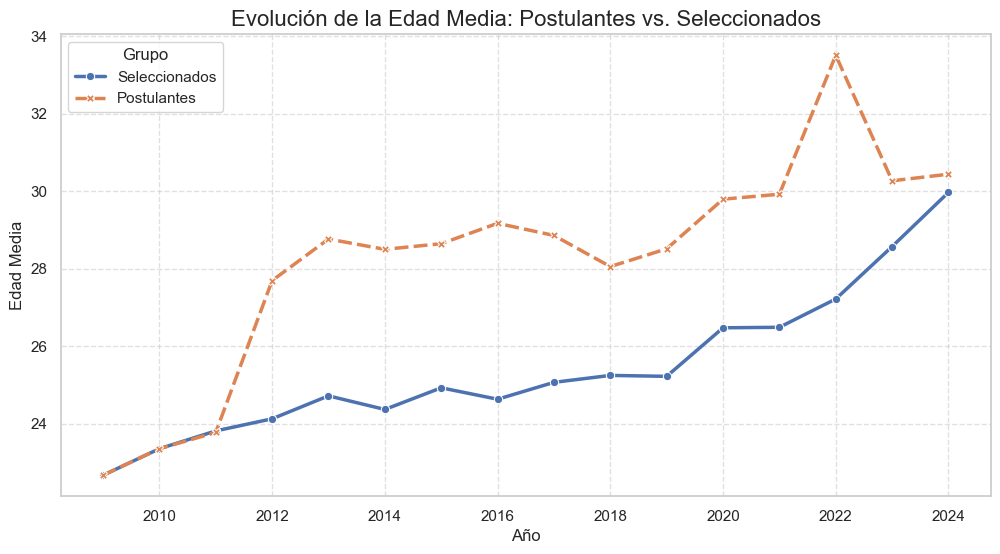

In [240]:
df_gen_temp = df_eda_general.rename(columns={'Año Pech': 'Año'})
df_gen_temp = df_gen_temp.dropna(subset=['Año', 'Edad'])
df_gen_temp['Año'] = df_gen_temp['Año'].astype(int)


df_sel_temp = df_eda_seleccionados.dropna(subset=['Año', 'Edad'])
df_sel_temp['Año'] = df_sel_temp['Año'].astype(int)


avg_age_sel = df_sel_temp.groupby('Año')['Edad'].mean().reset_index(name='Edad Media')
avg_age_sel['Grupo'] = 'Seleccionados'

avg_age_gen = df_gen_temp.groupby('Año')['Edad'].mean().reset_index(name='Edad Media')
avg_age_gen['Grupo'] = 'Postulantes'

df_comparativo_temporal = pd.concat([avg_age_sel, avg_age_gen])


plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_comparativo_temporal,
    x='Año',
    y='Edad Media',
    hue='Grupo',
    style='Grupo',
    markers=True,
    linewidth=2.5
)

ax.set_title('Evolución de la Edad Media: Postulantes vs. Seleccionados', fontsize=16)
ax.set_xlabel('Año')
ax.set_ylabel('Edad Media')
#ax.set(xlim=(2010, 2025))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Grupo')
plt.show();

Al observar ambos gráficos, se aprecia una clara tendencia al rejuvenecimiento en las edades tanto de los postulantes como de los seleccionados a lo largo de los años. En los últimos periodos, la edad media de los seleccionados se ha mantenido alrededor de cuatro años por debajo de la de los postulantes, lo que sugiere que los candidatos más jóvenes tienden a tener mayores probabilidades de ser seleccionados.

Esta diferencia constante plantea una interrogante relevante: ¿la edad actúa realmente como un factor determinante en el proceso de selección, o más bien el enfoque institucional hacia postulantes más jóvenes ha provocado una disminución en la participación de personas mayores?

### 5.1.2 Analisis de tendencias etarias en los procesos de seleccion

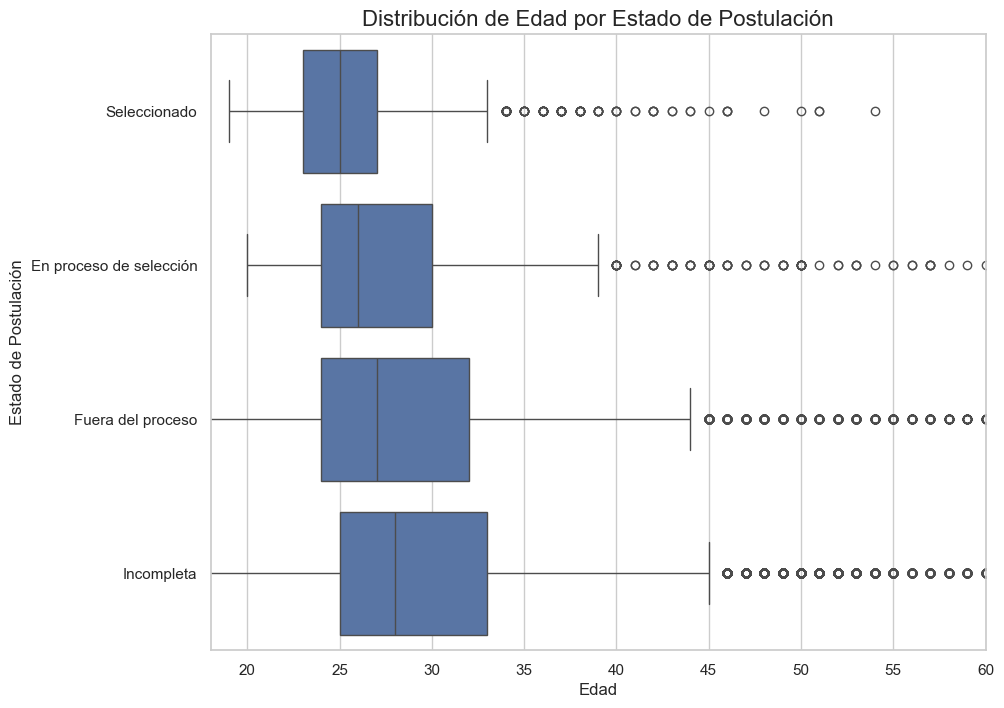

In [241]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(data=df_eda_general,
            x='Edad',
            y='Resumen Estado Postulación')

plt.title('Distribución de Edad por Estado de Postulación', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Estado de Postulación', fontsize=12)
ax.set_xlim(18, 60)

plt.show()

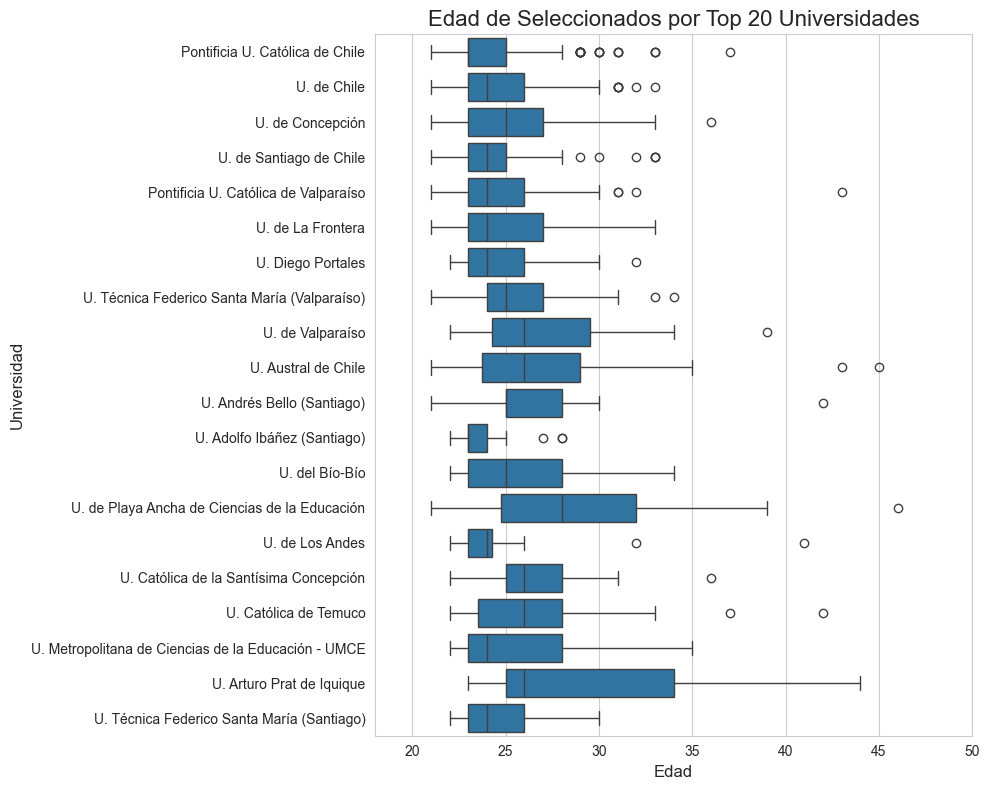

In [ ]:
conteo_universidades = df_eda_seleccionados['Universidad'].value_counts()

N = 20
universidades_top_N = conteo_universidades.head(N).index

df_top_N = df_eda_seleccionados[
    df_eda_seleccionados['Universidad'].isin(universidades_top_N)
]


plt.figure(figsize=(10, 8))


ax = sns.boxplot(data=df_top_N,
            x='Edad',
            y='Universidad',
            order=universidades_top_N)

plt.title(f'Edad de Seleccionados por Top {N} Universidades', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Universidad', fontsize=12)
ax.set_xlim(18, 50)
plt.tight_layout()
plt.show()
plt.show()

Se puede observar de los gráficos que la mayoría de los postulantes se concentran entre los 30 y 40 años, este rango etario también predomina entre los seleccionados, lo que sugiere que se favorece a perfiles con cierta experiencia profesional.
Los postulantes mas jóvenes tienden ser quienes no completan su postulación o quedan fuera del proceso, mientras que el rango etario de mayores de 50 años participan en menor medida.
En cuanto a las universidades, se puede observar que los seleccionados de universidades privadas de la región metropolitana presentan edades mas bajas, mientras que los provenientes de universidades regionales o tradicionales presentan edades mayores, esto refleja diversidad etaria del grupo seleccionado.

### 5.1.3 Analisis de distribucion entre universidades, carrera y edad

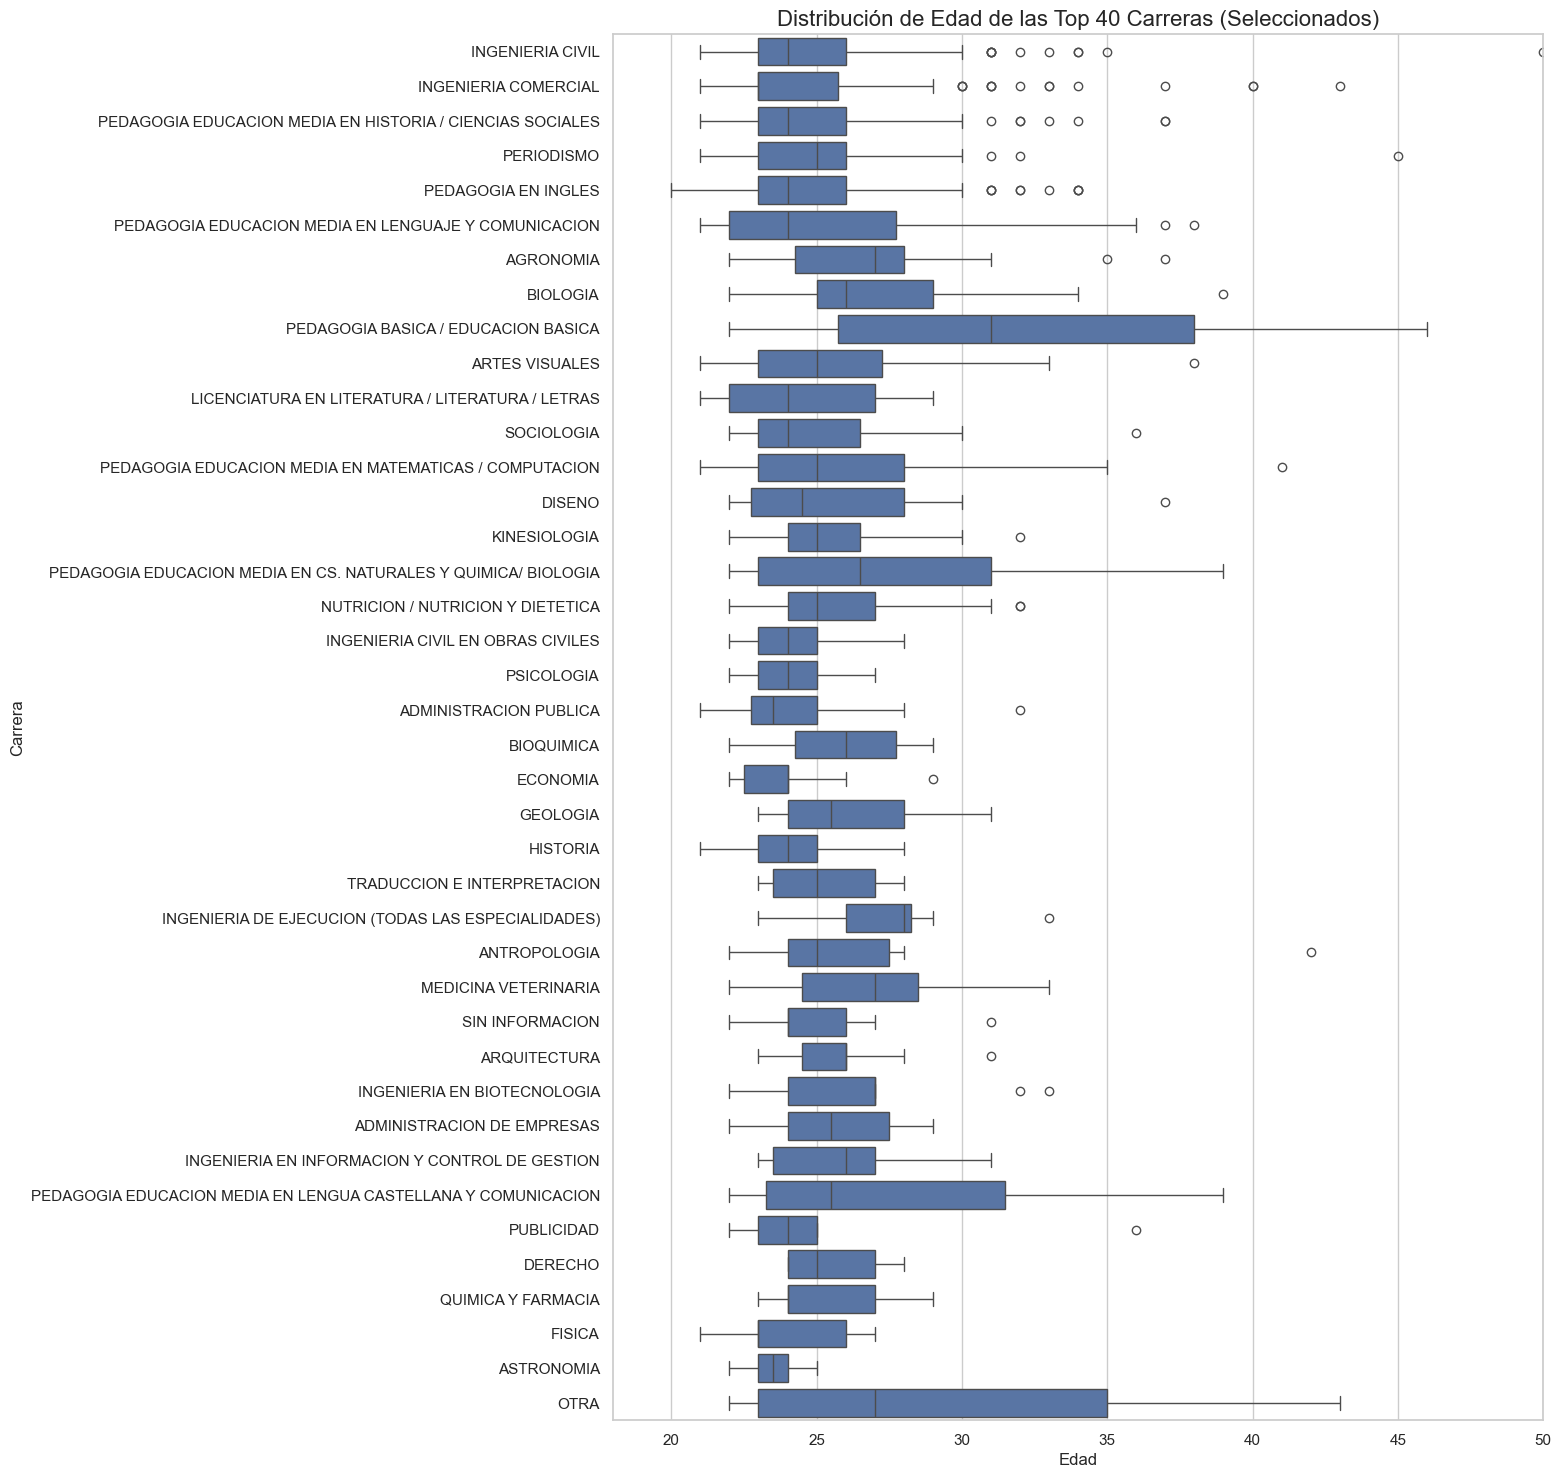

In [242]:
N = 40

# Contamos cuántos seleccionados hay por carrera
conteo_carreras = df_eda_seleccionados['Carrera'].value_counts()

# Obtenemos la lista de las Top N carreras (sus nombres)
carreras_top_N = conteo_carreras.head(N).index

# Filtramos el DataFrame para quedarnos solo con las filas de esas Top N carreras
df_filtrado_topN = df_eda_seleccionados[
    df_eda_seleccionados['Carrera'].isin(carreras_top_N)
]
altura_figura = max(15, N * 0.45)

fig, ax = plt.subplots(1, 1, figsize=(12, altura_figura))

sns.boxplot(
    data=df_filtrado_topN,
    x='Edad',
    y='Carrera',
    order=carreras_top_N,
    ax=ax
)

ax.set_title(f'Distribución de Edad de las Top {N} Carreras (Seleccionados)', fontsize=16)
ax.set_xlabel('Edad', fontsize=12)
ax.set_ylabel('Carrera', fontsize=12)
ax.set_xlim(18, 50)

plt.show()

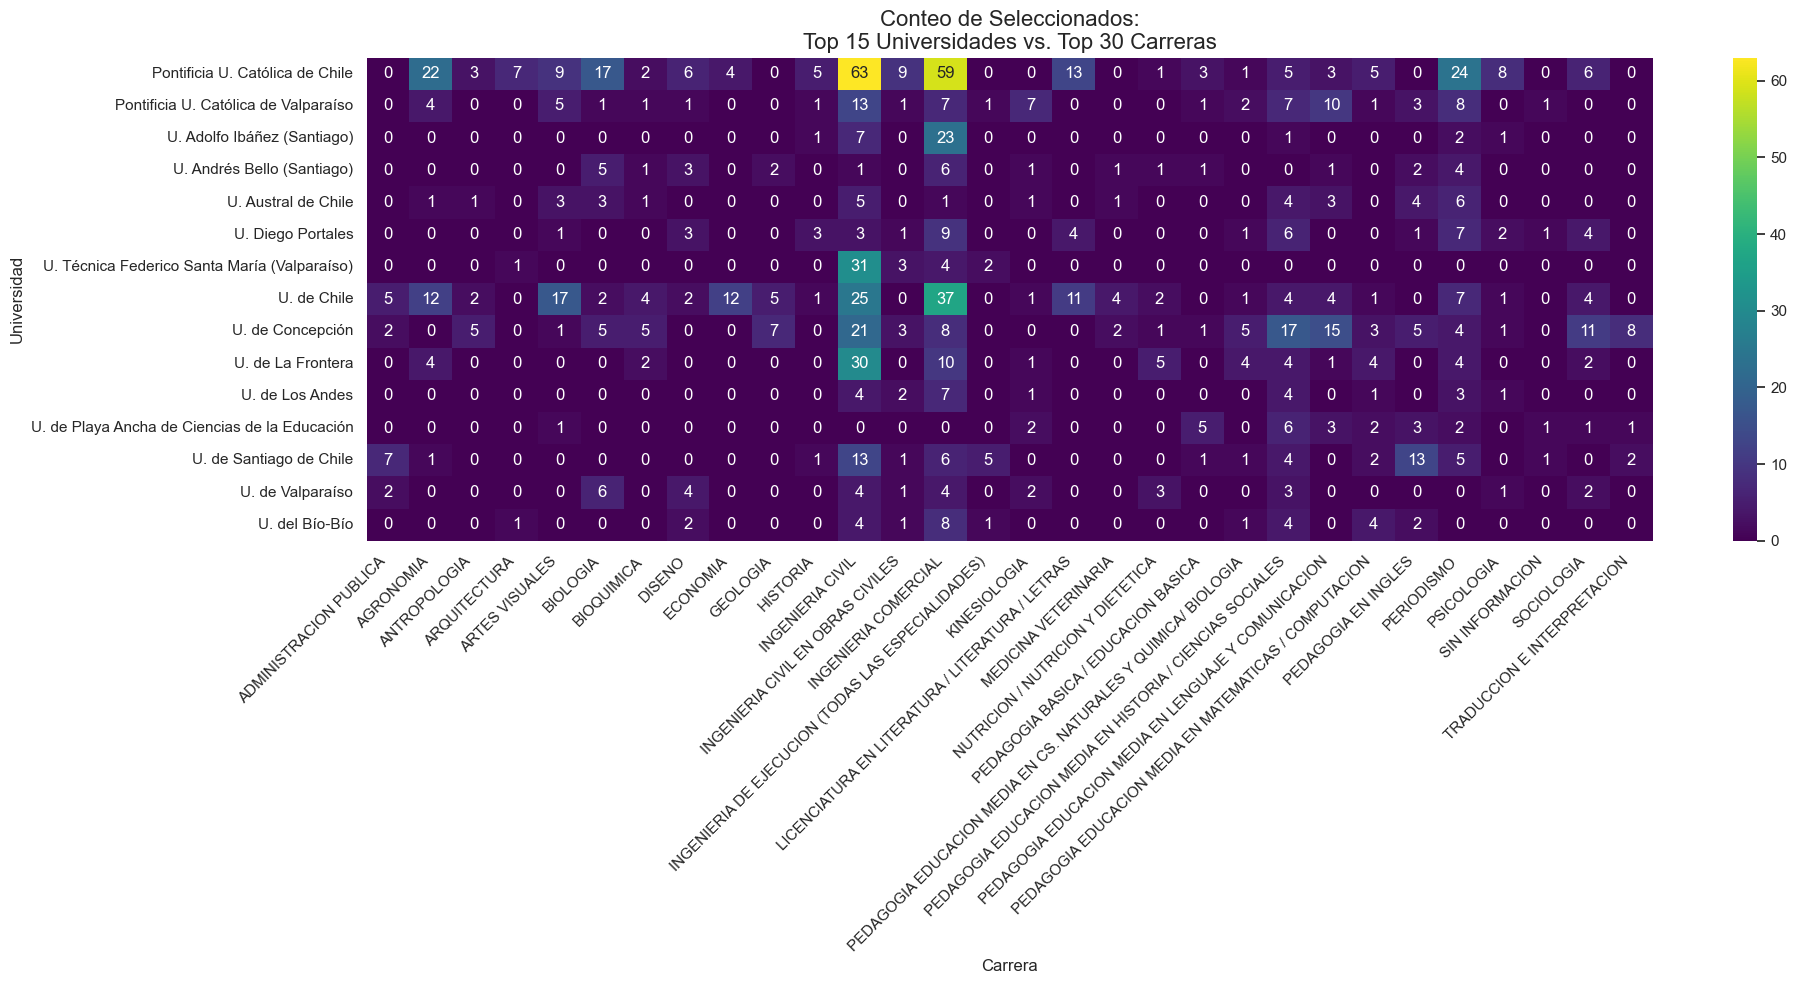

In [243]:
N_universidades = 15
N_carreras = 30

conteo_universidades = df_eda_seleccionados['Universidad'].value_counts()
top_universidades = conteo_universidades.head(N_universidades).index


conteo_carreras = df_eda_seleccionados['Carrera'].value_counts()
top_carreras = conteo_carreras.head(N_carreras).index


df_filtrado_heatmap = df_eda_seleccionados[
    df_eda_seleccionados['Universidad'].isin(top_universidades) &
    df_eda_seleccionados['Carrera'].isin(top_carreras)
]

tabla_contingencia = pd.crosstab(
    df_filtrado_heatmap['Universidad'],
    df_filtrado_heatmap['Carrera']
)


fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    tabla_contingencia,
    annot=True,
    fmt='d',
    cmap='viridis',
    ax=ax
)


ax.set_title(f'Conteo de Seleccionados:\nTop {N_universidades} Universidades vs. Top {N_carreras} Carreras', fontsize=16)
ax.set_xlabel('Carrera', fontsize=12)
ax.set_ylabel('Universidad', fontsize=12)


plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

fig.tight_layout()
plt.show()

## 5.2 Tendencias en el tiempo (por universidad/carrera)
Para cumplir con los objetivos del proyecto, no basta con saber qué universidades o carreras tienen más seleccionados en total. Necesitamos entender la evolución y la consistencia de estas cifras (Objetivos 1 y 2). El reclutamiento es un proceso dinámico; las universidades que eran prioritarias hace una década podrían no serlo hoy.

Para analizar las tendencias, se generaron tres visualizaciones clave, cada una con un propósito específico. En todas ellas, se decidió filtrar por el "Top 10" (de universidades o carreras) como un equilibrio y para mayor legibilidad, dado que mostrar todas las categorías resultaría en un gráfico de indescifrable.

In [244]:
# @title
df_general_temporal = df_eda_general.rename(columns={'Año Pech': 'Año'})
df_general_temporal = df_general_temporal.dropna(subset=['Año'])
df_general_temporal['Año'] = df_general_temporal['Año'].astype(int)

df_seleccionados_temporal = df_eda_seleccionados.dropna(subset=['Año'])
df_seleccionados_temporal['Año'] = df_seleccionados_temporal['Año'].astype(int)

C:\Users\sergi\AppData\Local\Temp\ipykernel_1472\1586719865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seleccionados_temporal['Año'] = df_seleccionados_temporal['Año'].astype(int)


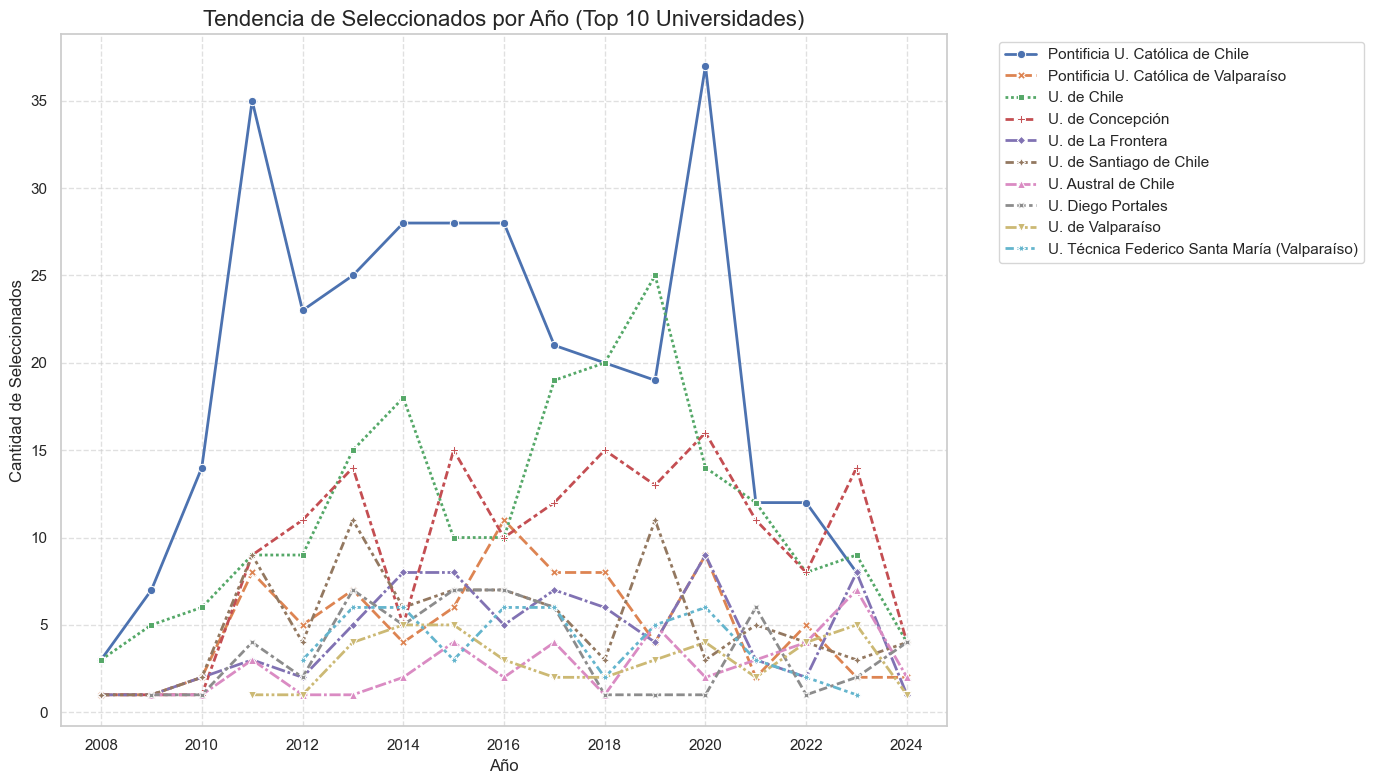

In [245]:
# @title


N_Ues = 10
top_universidades = df_seleccionados_temporal['Universidad'].value_counts().head(N_Ues).index


df_seleccionados_top_u = df_seleccionados_temporal[
    df_seleccionados_temporal['Universidad'].isin(top_universidades)
]


tendencia_por_universidad = df_seleccionados_top_u.groupby(
    ['Año', 'Universidad']
).size().reset_index(name='Cantidad Seleccionados')

plt.figure(figsize=(14, 8))
sns.lineplot(data=tendencia_por_universidad,
             x='Año',
             y='Cantidad Seleccionados',
             hue='Universidad',
             style='Universidad',
             markers=True,
             linewidth=2)

plt.title(f'Tendencia de Seleccionados por Año (Top {N_Ues} Universidades)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Seleccionados', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

Este gráfico muestra el conteo absoluto de seleccionados provenientes de las 10 universidades con más seleccionados históricos.

Resultados y Conclusiones Preliminares:

- Es evidente que la Pontificia U. Católica de Chile (línea azul sólida) y la U. de Chile (línea verde punteada) dominan en términos de volumen de seleccionados, superandoa las demás.

- Las cifras no son estables. Se observa un peak extremo para la PUC alrededor de 2021. Esto genera la pregunta:
  1. ¿Qué ocurrió ese año?
  2. ¿Se llevo a cabo una campaña de  reclutamiento diferente?
  3. ¿Fue un efecto de la pandemia?

- Casi todas las universidades muestran una fuerte caída en el número de seleccionados después de 2021-2022. Esto debe investigarse.
  1. ¿Es un reflejo de datos incompletos?
  2. ¿Es una señal de una crisis en el reclutamiento de Enseña Chile?

Processing region: Norte...


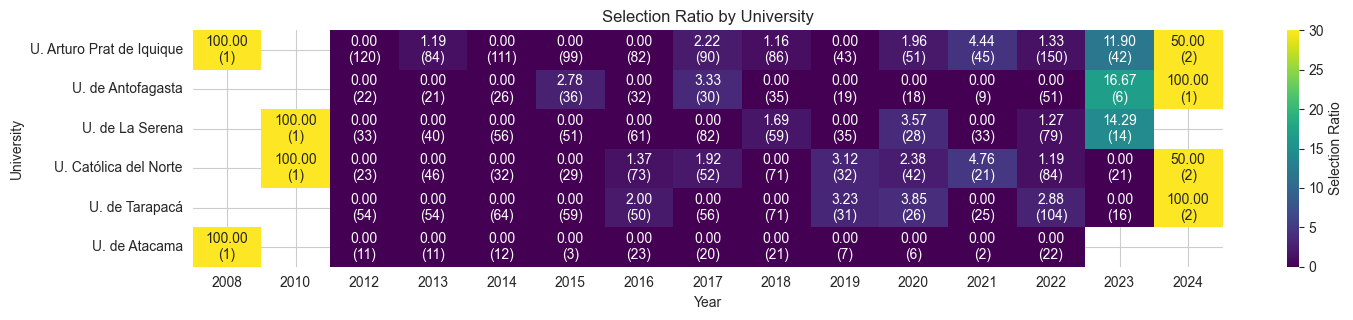

Processing region: Centro-Norte...


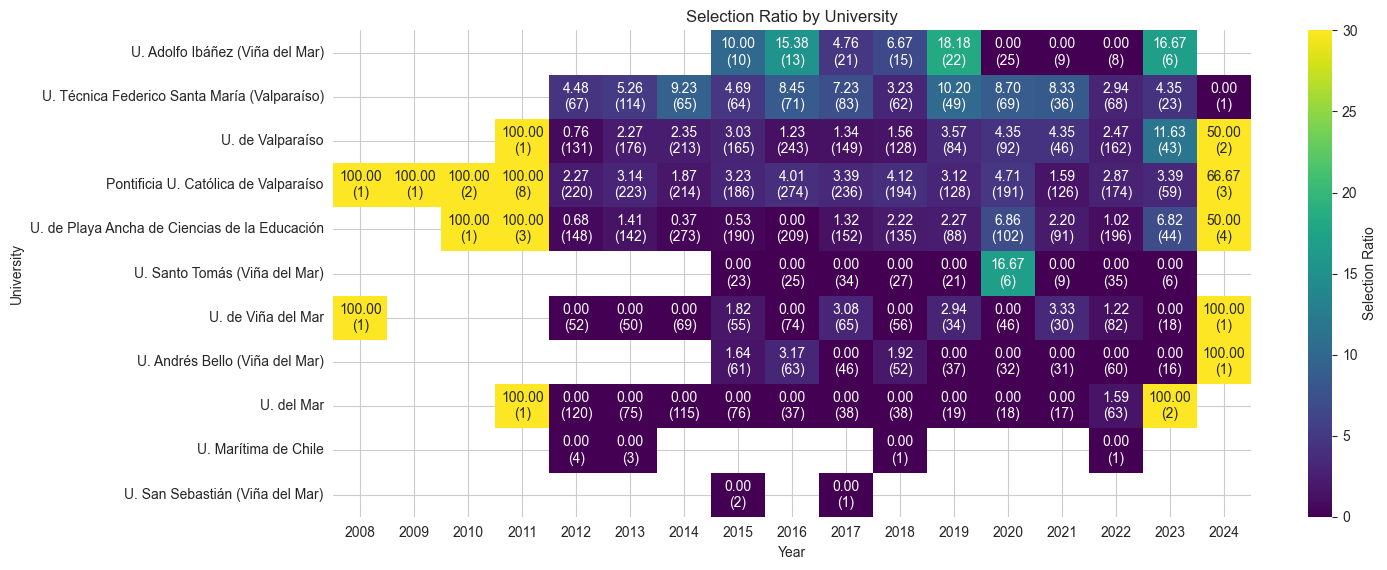

Processing region: Metropolitana...


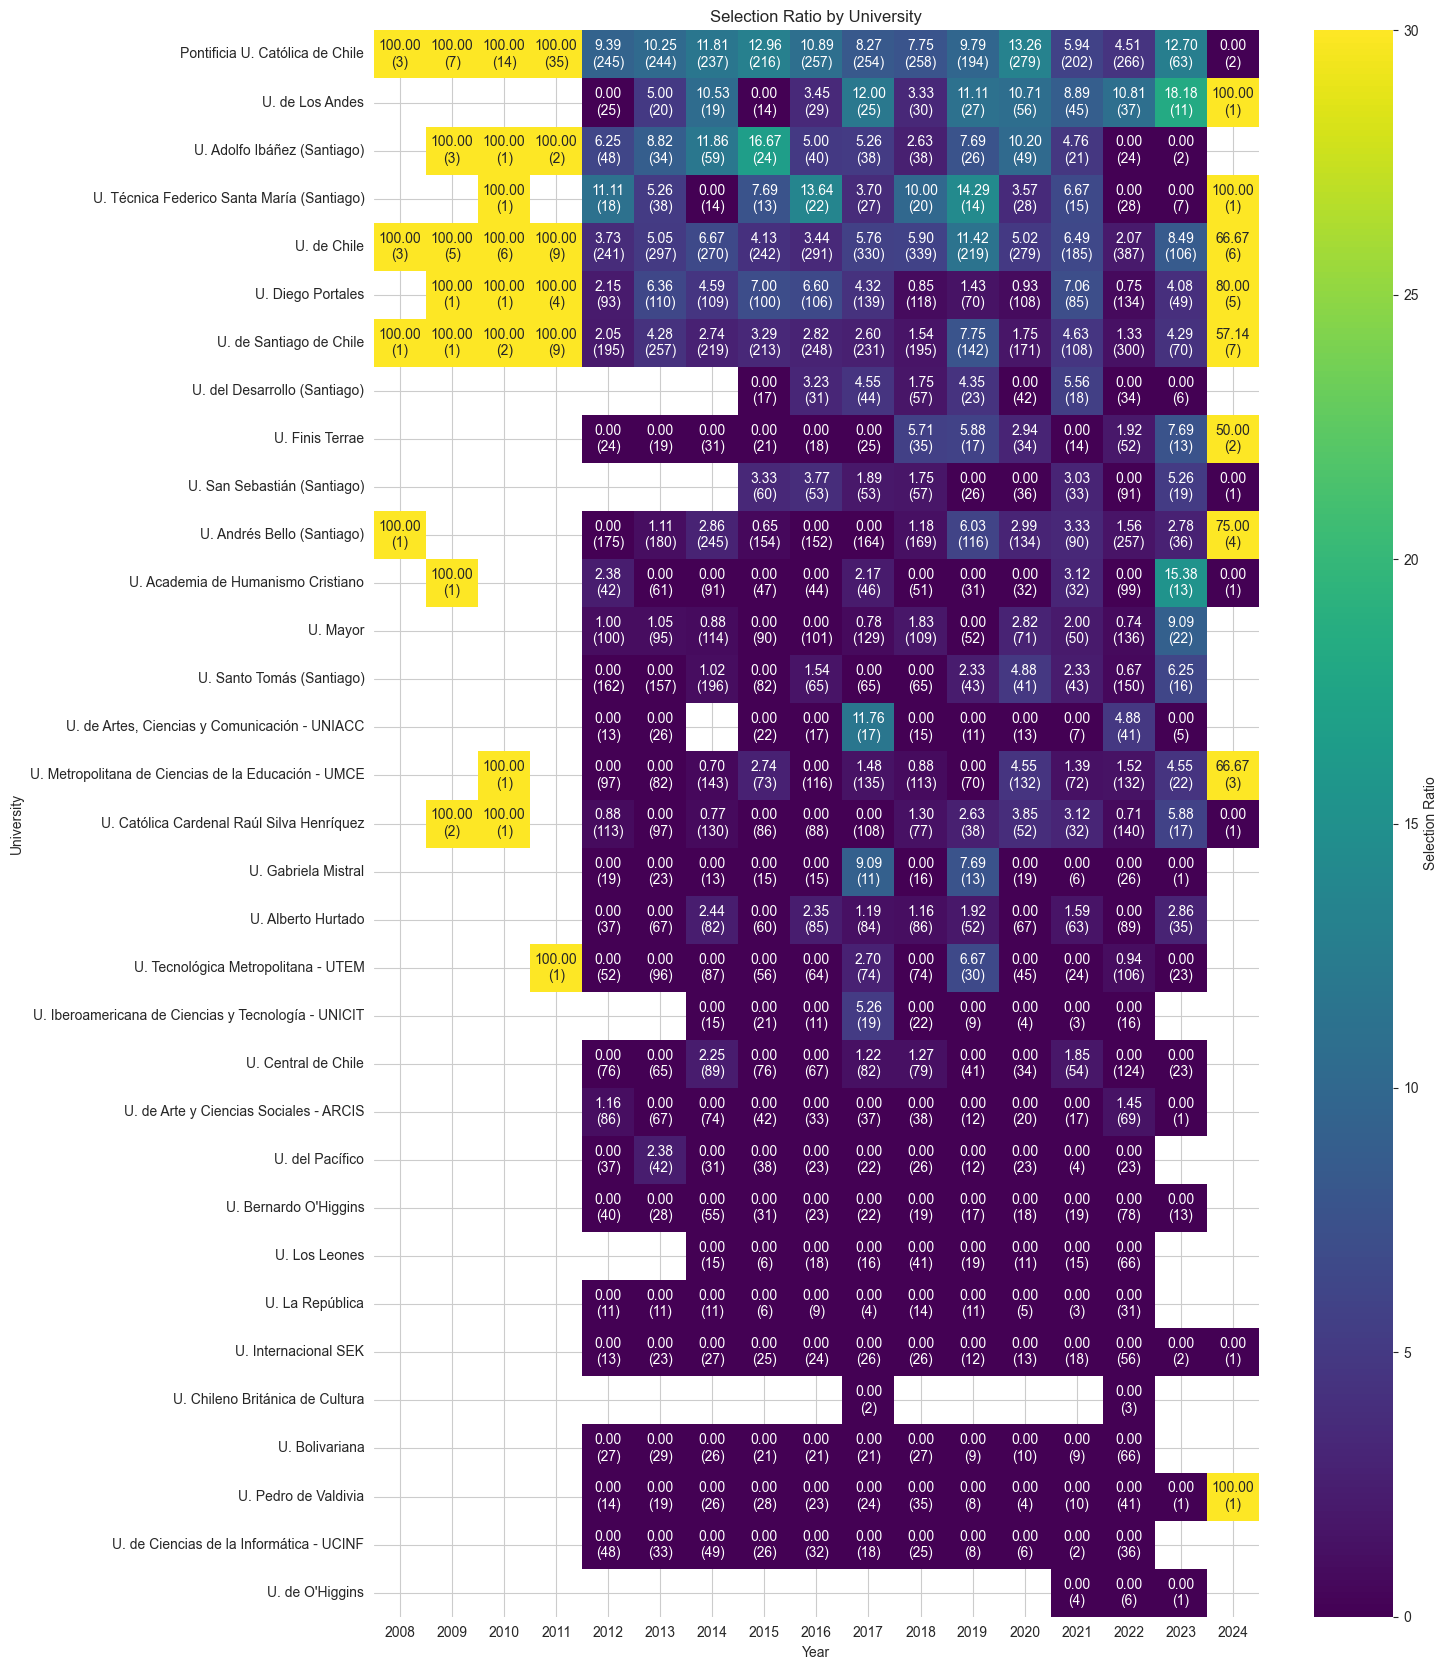

Processing region: Centro-Sur...


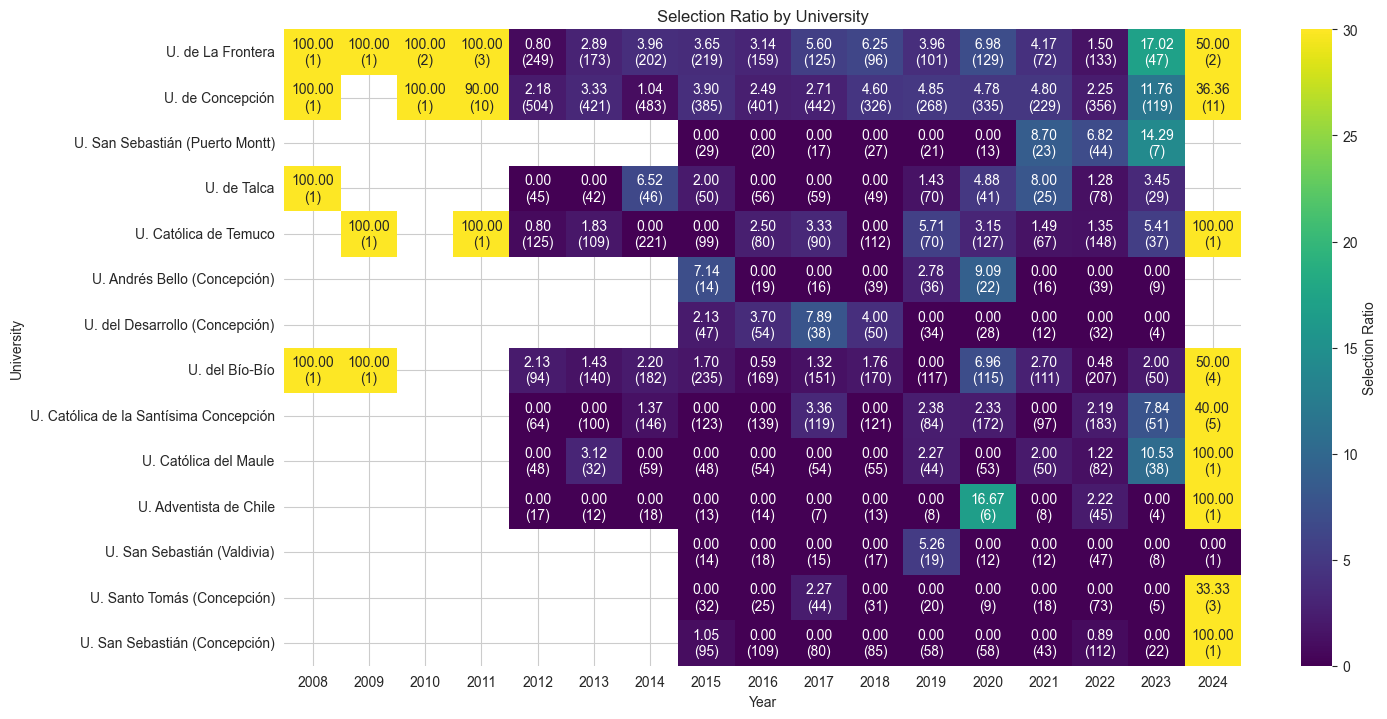

Processing region: Patagonia...


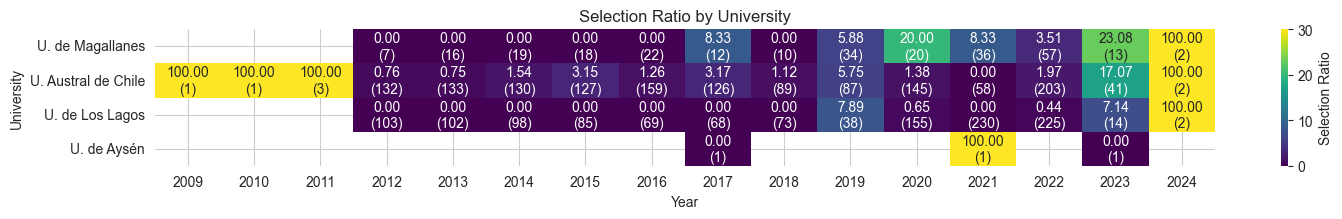

Processing region: No especifica...


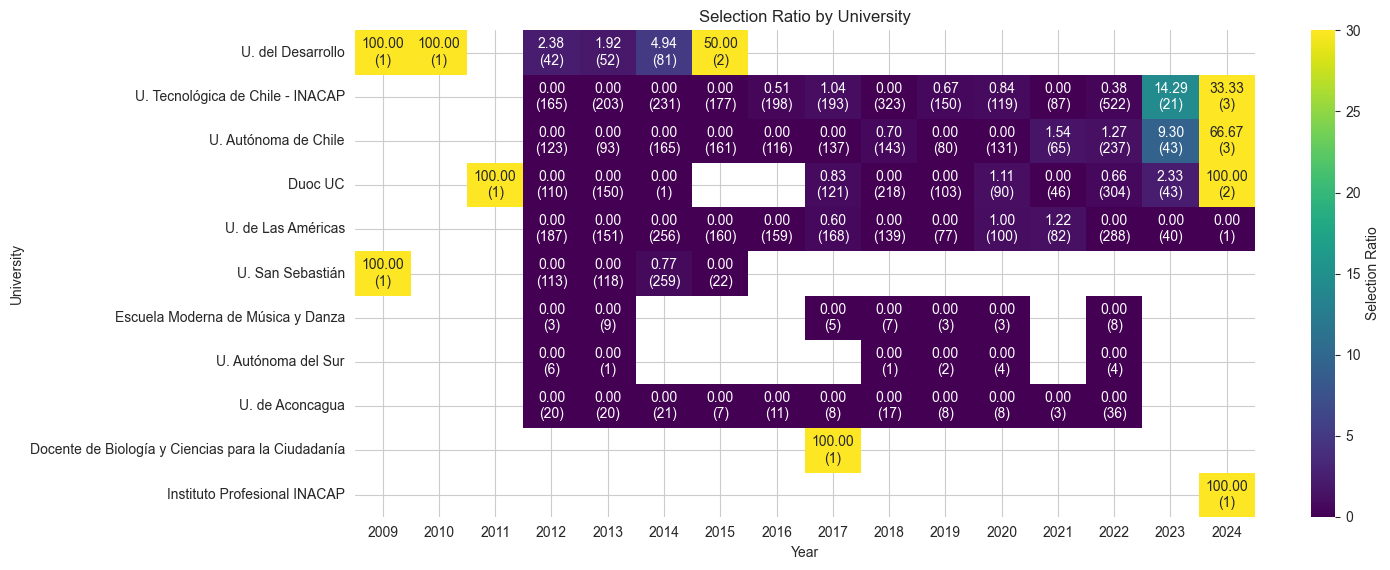

In [23]:
# 2. DATA CLEANING
# Discard rows with null values in "university" or "year"
df_cleaned = df_postulantes.dropna(subset=['Universidad', 'Año']).copy()

# Treat null values in "selection" as "not selected"
df_cleaned['Estado de la Postulación'] = df_cleaned['Estado de la Postulación'].fillna('not selected')

# Convert selection to binary (1 for selected, 0 for not)
df_cleaned['is_selected'] = df_cleaned['Estado de la Postulación'].apply(lambda x: 100 if x == 'Acepta compromiso peCh' else 0)

# 3. PROCESS EACH REGION
regions = ('Norte', 'Centro-Norte', 'Metropolitana', 'Centro-Sur', 'Patagonia', 'No especifica')

for region in regions:
    print(f"Processing region: {region}...")

    # Filter data for the current region
    region_data = df_cleaned[df_cleaned['Zona'] == region]

    # Calculate Mean (Ratio) and Count (N) simultaneously
    # observed=True prevents empty rows for universities not in this region
    pivot_agg = region_data.groupby(['Universidad', 'Año'], observed=True)['is_selected'].agg(['mean', 'count'])

    # Split into two tables: one for the heatmap color, one for the count
    pivot_ratio = pivot_agg['mean'].unstack()
    pivot_count = pivot_agg['count'].unstack()

    # --- SORTING LOGIC ---
    # 1. Flatten the data to evaluate individual cells
    ratios_long = pivot_ratio.stack()

    # 2. Filter: Only consider values strictly below 30% (0.30)
    valid_ratios = ratios_long[ratios_long < 30]

    # 3. Calculate sorting score: Average of "valid" years for each university
    ranking_score = valid_ratios.groupby('Universidad', observed=True).mean()

    # 4. Sort universities descending by this score
    sorted_universities = ranking_score.sort_values(ascending=False).index.tolist()

    # 5. Handle "Unreliable" Universities (those with NO years < 30%)
    # These were filtered out of 'ranking_score', so we add them to the bottom
    all_universities = pivot_ratio.index.tolist()
    unreliable_universities = [u for u in all_universities if u not in sorted_universities]

    # 6. Create Final Order
    final_order = sorted_universities + unreliable_universities

    # Reorder both pivot tables
    pivot_ratio_sorted = pivot_ratio.reindex(final_order)
    pivot_count_sorted = pivot_count.reindex(final_order)

    # --- ANNOTATION MATRIX ---
    # Build a table of strings: "0.25\n(N=120)"
    annot_labels = pd.DataFrame(index=pivot_ratio_sorted.index, columns=pivot_ratio_sorted.columns)

    for r_idx in pivot_ratio_sorted.index:
        for c_idx in pivot_ratio_sorted.columns:
            val = pivot_ratio_sorted.loc[r_idx, c_idx]
            count = pivot_count_sorted.loc[r_idx, c_idx]

            if pd.isna(val):
                annot_labels.loc[r_idx, c_idx] = ""
            else:
                # Format: Ratio (2 decimals) + Newline + Count (Integer)
                annot_labels.loc[r_idx, c_idx] = f"{val:.2f}\n({int(count)})"

    # --- PLOTTING ---
    plt.figure(figsize=(15, 0.3 + len(final_order) * 0.5)) # Adjust height dynamically based on rows
    sns.heatmap(
        pivot_ratio_sorted,
        annot=annot_labels, # Use our custom text matrix
        fmt='',             # Must be empty string so it accepts raw text
        cmap='viridis',     # High contrast colormap
        vmin=0.0,
        vmax= 30,           # Cap scale at 0.5 to highlight differences in low values
        cbar_kws={'label': 'Selection Ratio'}
    )

    plt.title(f'Selection Ratio by University')
    plt.ylabel('University')
    plt.xlabel('Year')
    plt.tight_layout()

    # Save file
    plt.show()

In [ ]:
for region in regions:
    region_data = df_cleaned[df_cleaned['region'] == region]

    # 1. Get BOTH Mean (Ratio) and Count
    # groupby(...).agg(['mean', 'count']) gets us both stats at once
    pivot_agg = region_data.groupby(['university', 'year'], observed=True)['is_selected'].agg(['mean', 'count'])

    # Split them into separate pivot tables
    pivot_ratio = pivot_agg['mean'].unstack()
    pivot_count = pivot_agg['count'].unstack()

    # ... (Insert your Sorting Logic Here to reindex both tables) ...
    # pivot_ratio_sorted = pivot_ratio.reindex(final_order)
    # pivot_count_sorted = pivot_count.reindex(final_order)

    # 2. Build the Custom Annotation Matrix (The Labels)
    # We iterate through the table to format the string: "0.25\n(N=12)"
    annot_labels = pd.DataFrame(index=pivot_ratio_sorted.index, columns=pivot_ratio_sorted.columns)

    for r_idx in pivot_ratio_sorted.index:
        for c_idx in pivot_ratio_sorted.columns:
            val = pivot_ratio_sorted.loc[r_idx, c_idx]
            count = pivot_count_sorted.loc[r_idx, c_idx]

            # If data is missing (NaN), leave the label empty
            if pd.isna(val):
                annot_labels.loc[r_idx, c_idx] = ""
            else:
                annot_labels.loc[r_idx, c_idx] = f"{val:.2f}\n(N={int(count)})"

    # 3. Plotting
    plt.figure(figsize=(12, 8)) # Make it slightly larger to fit the extra text
    sns.heatmap(
        pivot_ratio_sorted,
        annot=annot_labels, # <--- Pass the custom string labels here
        fmt='',             # <--- Important: Set fmt to empty string so it accepts our text without formatting errors
        cmap='viridis',
        vmin=0.0,
        vmax=0.5
    )
    plt.title(f'Selection Ratio - {region}')
    plt.savefig(f'heatmap_annotated_{region}.png')
    plt.close()

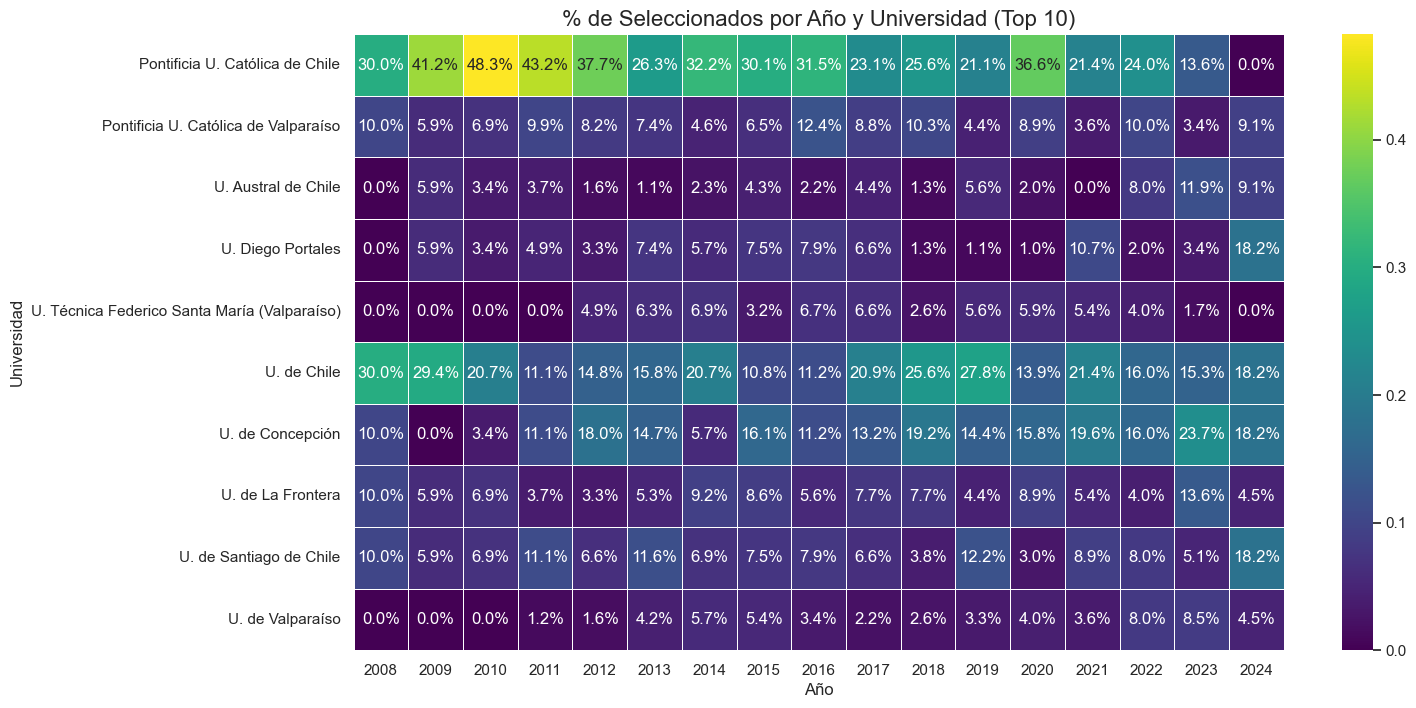

In [246]:
# @title
df_pivot_u = tendencia_por_universidad.pivot_table(
    index='Universidad',
    columns='Año',
    values='Cantidad Seleccionados'
).fillna(0)

df_pivot_u_norm = df_pivot_u.apply(lambda x: x / x.sum(), axis=0)


plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot_u_norm,
            annot=True,
            fmt='.1%',
            cmap='viridis',
            linewidths=.5)

plt.title(f'% de Seleccionados por Año y Universidad (Top {N_Ues})', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Universidad', fontsize=12)
plt.show();

Este grafico muestra qué porcentaje del total de seleccionados de un año específico aportó cada una de las Top 10 universidades.

Resultados y Conclusiones Preliminares:

Este gráfico responde directamente a la Pregunta 5. Confirma que la concentración en la PUC y U. de Chile es real. En la mayoría de los años, estas dos instituciones suman entre el 40% y el 60% de todos los seleccionados  Esto sugiere un fuerte sesgo histórico hacia estas instituciones.

La U. de Concepción y PUCV muestran una participación proporcional consistente (8%-15%) del total anual. Esto las posiciona como objetivos de reclutamiento fiables.

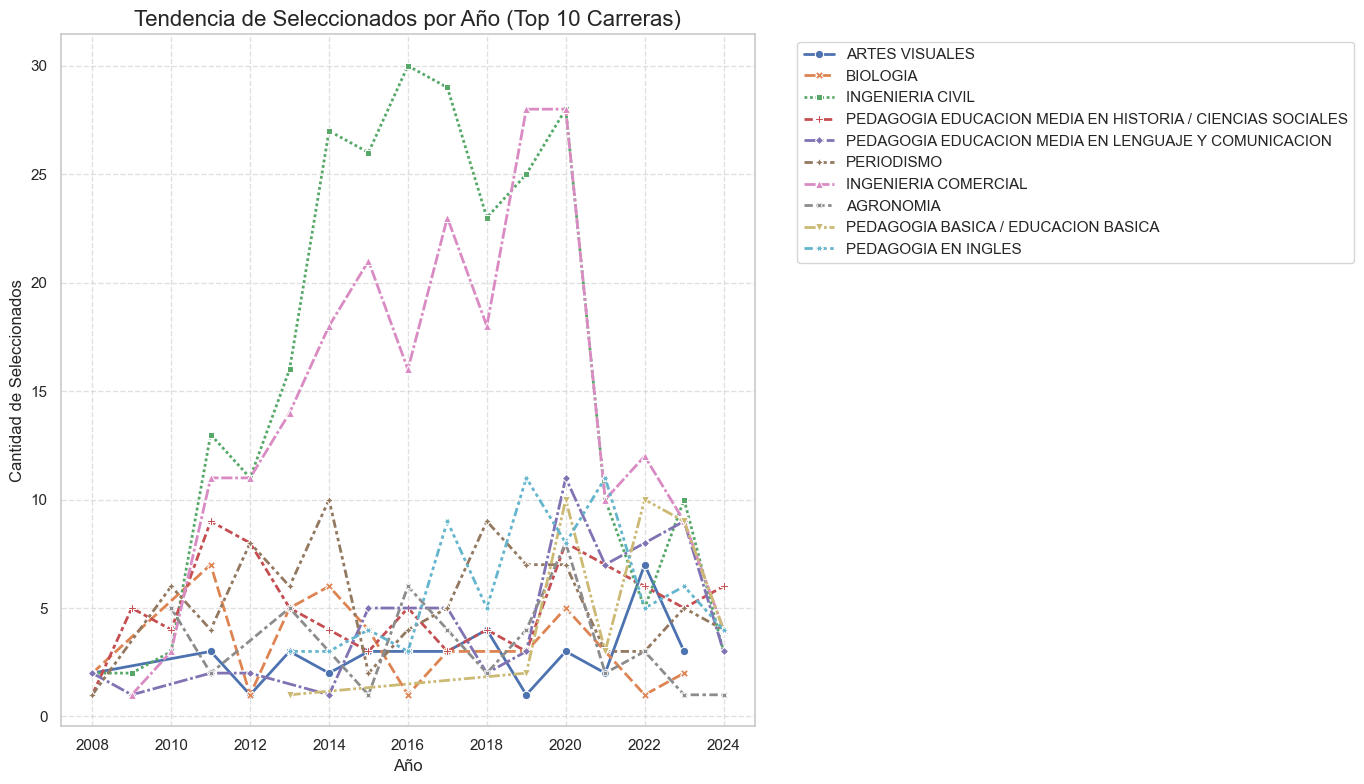

In [247]:
# @title
N_Carreras = 10
top_carreras = df_seleccionados_temporal['Carrera'].value_counts().head(N_Carreras).index

df_seleccionados_top_c = df_seleccionados_temporal[
    df_seleccionados_temporal['Carrera'].isin(top_carreras)
]

tendencia_por_carrera = df_seleccionados_top_c.groupby(
    ['Año', 'Carrera']
).size().reset_index(name='Cantidad Seleccionados')

plt.figure(figsize=(14, 8))
sns.lineplot(data=tendencia_por_carrera,
             x='Año',
             y='Cantidad Seleccionados',
             hue='Carrera',
             style='Carrera',
             markers=True,
             linewidth=2)

plt.title(f'Tendencia de Seleccionados por Año (Top {N_Carreras} Carreras)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Seleccionados', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

El grafico muestra el número de seleccionados provenientes de las 10 carreras más frecuentes en la historia del programa.

Resultados y Conclusiones Preliminares:

- El hallazgo más importante es la dominancia de dos carreras: Ingenieria Civil (línea roja punteada) e Ingeniería Comercial (línea azul). Históricamente, estas dos carreras son las que mas aportan a los seleccionados.

- Esto impacta directamente el Objetivo 3 (identificar carreras prioritarias). Estas dos son, por volumen, las más importantes.

- Este gráfico genera preguntas interesantes para Enseña Chile:

  1. ¿Por qué estas dos carreras? ¿Son el foco principal de las campañas de reclutamiento? ¿O son las que calzan con el perfil de reclutamiento?

  2. ¿Por qué carreras aparentemente más alineadas con la misión como las Pedagogías tienen números tan bajos?

  3. ¿Desea la fundación diversificar este perfil?

## 5.3 Exploracion mineduc

In [248]:
df_titulados_completo.head()

,cat_periodo,nomb_carrera,nivel_carrera_1,nombre_titulo_obtenido,nomb_inst,region_sede,area_conocimiento,carrera_agrupada
0,2024,CONTADOR AUDITOR,Profesional Con Licenciatura,CONTADOR AUDITOR,UNIVERSIDAD SAN SEBASTIAN,Metropolitana,Administración y Comercio,AUDITOR
1,2024,INGENIERIA CIVIL MATEMATICA,Profesional Con Licenciatura,INGENIERO CIVIL MATEMATICO,UNIVERSIDAD DE CONCEPCION,Biobío,Ciencias Básicas,INGENIERIA
2,2024,INGENIERIA DE EJECUCION EN PREVENCION DE RIESGOS,Profesional Sin Licenciatura,INGENIERO DE EJECUCION EN PREVENCION DE RIESGOS,UNIVERSIDAD ARTURO PRAT,La Araucanía,Tecnología,INGENIERIA
3,2024,INGENIERIA COMERCIAL,Profesional Con Licenciatura,INGENIERO COMERCIAL CON MENCION EN ADMINISTRACION,UNIVERSIDAD DE LAS AMERICAS,Biobío,Administración y Comercio,INGENIERIA
4,2024,INGENIERIA EN CONSTRUCCION MENCION GESTION DE ...,Profesional Con Licenciatura,INGENIERO EN CONSTRUCCION MENCION GESTION DE O...,UNIVERSIDAD DE ACONCAGUA,Metropolitana,Tecnología,INGENIERIA


In [249]:
conteo_agrupada = df_titulados_completo['carrera_agrupada'].value_counts()

<Figure size 1200x600 with 0 Axes>

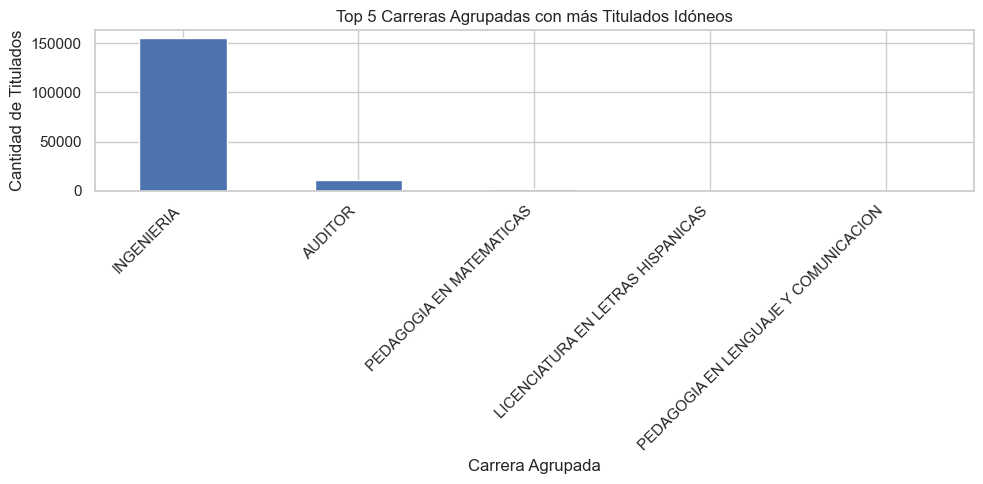

In [250]:
plt.figure(figsize=(12, 6))
plt.figure(figsize=(10, 5))
conteo_agrupada.head(5).plot(kind='bar')
plt.title('Top 5 Carreras Agrupadas con más Titulados Idóneos')
plt.xlabel('Carrera Agrupada')
plt.ylabel('Cantidad de Titulados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Conteo de Titulados por Institución (Universidades con más Pool)
nomb_inst
UNIVERSIDAD TECNOLOGICA DE CHILE INACAP          21991
UNIVERSIDAD ANDRES BELLO                         16404
UNIVERSIDAD TECNICA FEDERICO SANTA MARIA          8782
UNIVERSIDAD DE SANTIAGO DE CHILE                  8118
UNIVERSIDAD DE CHILE                              7507
UNIVERSIDAD ADOLFO IBAÑEZ                         6604
UNIVERSIDAD ARTURO PRAT                           6021
PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE          5642
UNIVERSIDAD SAN SEBASTIAN                         5332
PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO     5276
Name: count, dtype: int64


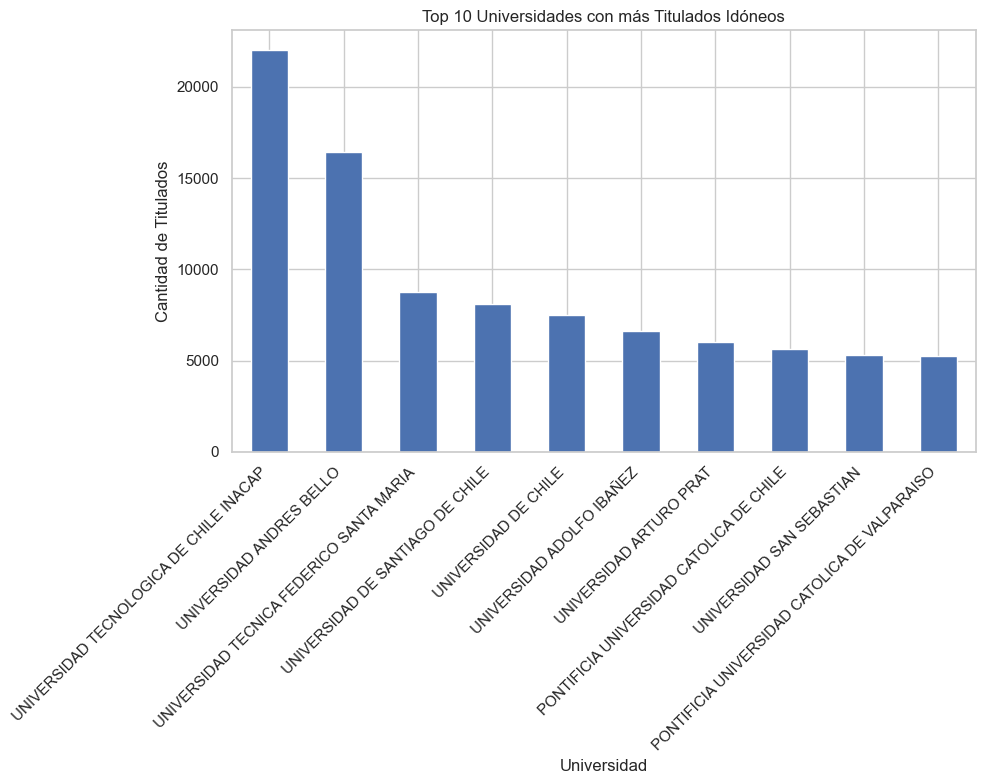

In [251]:
print("\n### Conteo de Titulados por Institución (Universidades con más Pool)")
conteo_inst = df_titulados_completo['nomb_inst'].value_counts()
print(conteo_inst.head(10))

plt.figure(figsize=(10, 8))
conteo_inst.head(10).plot(kind='bar')
plt.title('Top 10 Universidades con más Titulados Idóneos')
plt.xlabel('Universidad')
plt.ylabel('Cantidad de Titulados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\sergi\AppData\Local\Temp\ipykernel_1472\1349814255.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_titulados_completo.groupby('region_sede').size().sort_values(ascending=False).plot(kind='bar')


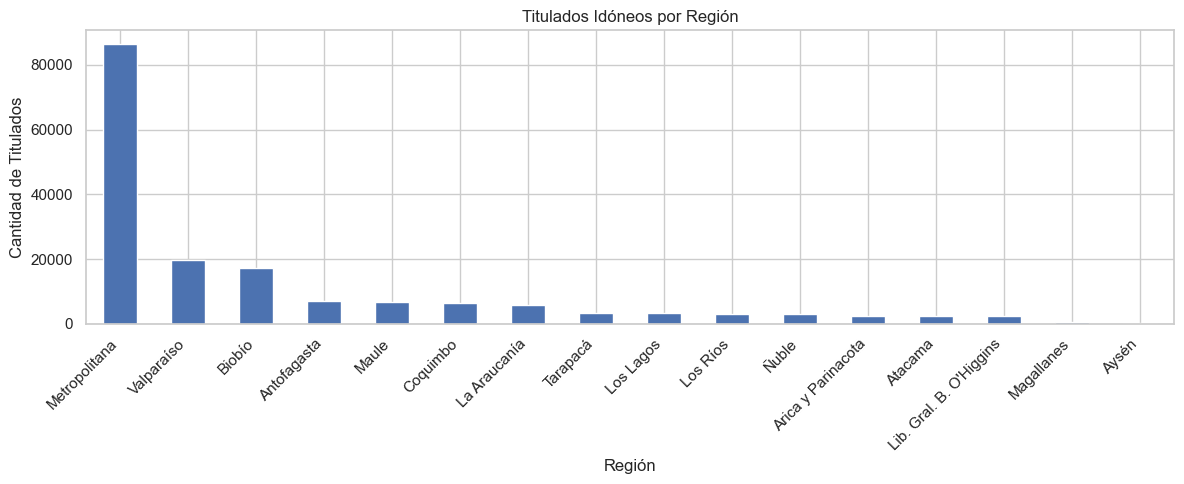

In [252]:
plt.figure(figsize=(12, 5))
df_titulados_completo.groupby('region_sede').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Titulados Idóneos por Región')
plt.xlabel('Región')
plt.ylabel('Cantidad de Titulados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Estadísticas descriptivas del puntaje de corte PAES
#print("\n### Estadísticas Descriptivas del Puntaje de Corte PAES (General)")
#print(df_titulados_completo['puntaje_corte_paes'].describe())

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='carrera_agrupada', y='puntaje_corte_paes',
            # data=df_titulados_completo[df_titulados_completo['carrera_agrupada'].isin(conteo_agrupada.head(5).index)])
# plt.title('Distribución del Puntaje de Corte PAES por Top 5 Carreras Agrupadas')
# plt.xlabel('Carrera Agrupada')
# plt.ylabel('Puntaje de Corte PAES')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

2.3 Puntajes ponderados de matriculados educación superior 2020-2024

In [253]:
BASE_PATH = Path("datasets/puntajes/")

def cambiar_formato_puntajes(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(",", ".", regex=False).str.strip()
    return pd.to_numeric(s, errors="coerce")

def crear_dfs(year: int, base_path: Path) -> pd.DataFrame:
    csv_path = base_path / f"ArchivoMatr_Adm{year}.csv"
    df = pd.read_csv(csv_path, sep=";")
    return df

df_2020 = crear_dfs(2020, BASE_PATH)
df_2021 = crear_dfs(2021, BASE_PATH)
df_2022 = crear_dfs(2022, BASE_PATH)
df_2023 = crear_dfs(2023, BASE_PATH)
df_2024 = crear_dfs(2024, BASE_PATH)

print("Puntajes 2020")
display(df_2020)
df_2020.info()
print("\n")
print("Puntajes 2021")
display(df_2021)
df_2021.info()
print("\n")
print("Puntajes 2022")
display(df_2022)
df_2022.info()
print("\n")
print("Puntajes 2023")
display(df_2023)
df_2023.info()
print("\n")
print("Puntajes 2024")
display(df_2024)
df_2024.info()


Puntajes 2020


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
0,id_797737971778,49,49005,1,3,529,2,1
1,id_056530575654,27,27023,1,1,534,1,1
2,id_666606670669,41,41068,1,1,"531,7",1,1
3,id_902969073298,16,16060,1,1,"692,05",1,1
4,id_570065773007,41,41194,1,1,"517,6",1,1
...,...,...,...,...,...,...,...,...
97987,id_5093580849461,50,50528,1,7,"477,67",1,1
97988,id_5593595644442,14,14072,1,1,"624,1",1,1
97989,id_9866988748576,15,15170,1,1,"722,3",1,1
97990,id_9866988341176,44,44001,1,1,"573,5",1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97992 entries, 0 to 97991
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID_aux          97992 non-null  object
 1   CODIGO_UNIV     97992 non-null  int64 
 2   CODIGO          97992 non-null  int64 
 3   VIA             97992 non-null  int64 
 4   PREFERENCIA     97992 non-null  int64 
 5   PTJE_POND       97992 non-null  object
 6   POND_ANYO_ACAD  97992 non-null  int64 
 7   TIPO_MATRICULA  97992 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.0+ MB


Puntajes 2021


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
0,id_896138975615,11,11021,1,2,"608,8",1,1
1,id_996709977679,20,20098,1,10,"588,25",1,2
2,id_996609977662,11,11087,1,2,"639,4",1,1
3,id_719207177929,52,52497,1,1,575,1,1
4,id_250302574037,53,53309,1,5,"579,45",1,1
...,...,...,...,...,...,...,...,...
92282,id_129414246719,26,26301,1,1,"610,9",1,1
92283,id_466541647727,40,40021,1,1,"563,91",1,1
92284,id_056408548155,49,49016,1,1,"638,44",1,1
92285,id_166615640372,46,46401,1,10,542,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92287 entries, 0 to 92286
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID_aux          92287 non-null  object
 1   CODIGO_UNIV     92287 non-null  int64 
 2   CODIGO          92287 non-null  int64 
 3   VIA             92287 non-null  int64 
 4   PREFERENCIA     92287 non-null  int64 
 5   PTJE_POND       92287 non-null  object
 6   POND_ANYO_ACAD  92287 non-null  int64 
 7   TIPO_MATRICULA  92287 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 5.6+ MB


Puntajes 2022


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
0,id_712837177285,34,34057,1,1,"548,6",2,1
1,id_962409670243,24,24017,1,2,"465,3",1,1
2,id_781807879181,41,41034,1,1,"501,2",1,1
3,id_155001578503,16,16100,1,1,"668,1",1,1
4,id_170201772022,11,11072,1,1,"608,2",1,1
...,...,...,...,...,...,...,...,...
95933,id_7666786448959,16,16004,1,2,"704,7",1,3
95934,id_7666786449275,45,45005,1,1,"615,3",1,1
95935,id_7666786443922,20,20098,3,2,"830,706",1,1
95936,id_7666786249480,12,12038,1,2,"652,2",1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95938 entries, 0 to 95937
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID_aux          95938 non-null  object
 1   CODIGO_UNIV     95938 non-null  int64 
 2   CODIGO          95938 non-null  int64 
 3   VIA             95938 non-null  int64 
 4   PREFERENCIA     95938 non-null  int64 
 5   PTJE_POND       95938 non-null  object
 6   POND_ANYO_ACAD  95938 non-null  int64 
 7   TIPO_MATRICULA  95938 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 5.9+ MB


Puntajes 2023


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
0,id_267832678788,30,30055,1,1,513.60,1
1,id_016130170616,45,45021,1,1,565.85,1
2,id_514305173430,56,56524,1,3,724.70,1
3,id_042500470254,47,47303,1,1,697.60,1
4,id_699806974987,45,45009,1,2,722.00,1
...,...,...,...,...,...,...,...
111292,id_8198841548154,32,32012,1,1,591.45,1
111293,id_7666786944704,50,50201,1,1,580.50,1
111294,id_7666786243268,32,32055,1,1,733.50,3
111295,id_7666786649432,51,51185,1,9,593.40,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111297 entries, 0 to 111296
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID_aux          111297 non-null  object 
 1   CODIGO_UNIV     111297 non-null  int64  
 2   CODIGO          111297 non-null  int64  
 3   VIA             111297 non-null  int64  
 4   PREFERENCIA     111297 non-null  int64  
 5   PTJE_POND       111297 non-null  float64
 6   TIPO_MATRICULA  111297 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.9+ MB


Puntajes 2024


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
0,id_690126976014,51,51111,1,1,"709,9",1
1,id_831408370144,18,18075,1,1,"713,45",1
2,id_752607579265,44,44049,1,1,"876,1",1
3,id_772307770236,21,21043,1,1,"643,3",2
4,id_481904877199,41,41067,1,1,"638,7",1
...,...,...,...,...,...,...,...
118354,id_676664741483,30,30038,1,3,"795,2",1
118355,id_686660840696,19,19019,1,1,"617,75",1
118356,id_9866988747341,41,41060,1,2,"745,35",1
118357,id_7666786745599,47,47201,1,1,"681,5",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118359 entries, 0 to 118358
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID_aux          118359 non-null  object
 1   CODIGO_UNIV     118359 non-null  int64 
 2   CODIGO          118359 non-null  int64 
 3   VIA             118359 non-null  int64 
 4   PREFERENCIA     118359 non-null  int64 
 5   PTJE_POND       118359 non-null  object
 6   TIPO_MATRICULA  118359 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 6.3+ MB


In [254]:
# Aseguramos los datos de puntajes ponderados como numero
df_2020["PTJE_POND"] = cambiar_formato_puntajes(df_2020["PTJE_POND"])
df_2021["PTJE_POND"] = cambiar_formato_puntajes(df_2021["PTJE_POND"])
df_2022["PTJE_POND"] = cambiar_formato_puntajes(df_2022["PTJE_POND"])
df_2023["PTJE_POND"] = cambiar_formato_puntajes(df_2023["PTJE_POND"])
df_2024["PTJE_POND"] = cambiar_formato_puntajes(df_2024["PTJE_POND"])

In [255]:
# Inspeccion de nulos y duplicados
print(f"Cantidad de datos nulos por columna 2020")
print(df_2020.isnull().sum())
print(f"El df del año 2020 tiene {df_2020.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2021")
print(df_2021.isnull().sum())
print(f"El df del año 2021 tiene {df_2021.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2022")
print(df_2022.isnull().sum())
print(f"El df del año 2022 tiene {df_2022.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2023")
print(df_2023.isnull().sum())
print(f"El df del año 2023 tiene {df_2023.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2024")
print(df_2024.isnull().sum())
print(f"El df del año 2024 tiene {df_2024.duplicated().sum()} filas con datos duplicados")
print("\n")

Cantidad de datos nulos por columna 2020
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
POND_ANYO_ACAD    0
TIPO_MATRICULA    0
dtype: int64
El df del año 2020 tiene 0 filas con datos duplicados


Cantidad de datos nulos por columna 2021
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
POND_ANYO_ACAD    0
TIPO_MATRICULA    0
dtype: int64
El df del año 2021 tiene 0 filas con datos duplicados


Cantidad de datos nulos por columna 2022
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
POND_ANYO_ACAD    0
TIPO_MATRICULA    0
dtype: int64
El df del año 2022 tiene 0 filas con datos duplicados


Cantidad de datos nulos por columna 2023
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
TIPO_MATRICULA    0
dtype: in

In [256]:
display(df_2020.describe())
display(df_2021.describe())
display(df_2022.describe())
display(df_2023.describe())
display(df_2024.describe())

,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
count,97992.000000,97992.000000,97992.000000,97992.000000,97992.000000,97992.000000,97992.000000
mean,29.974049,30079.499643,1.043197,1.771318,615.417596,1.125418,1.043789
std,13.816256,13850.435614,0.278055,1.597190,80.662268,0.331194,0.297642
min,11.000000,11001.000000,1.000000,1.000000,395.000000,1.000000,1.000000
25%,16.000000,16036.000000,1.000000,1.000000,554.150000,1.000000,1.000000
50%,30.000000,30085.000000,1.000000,1.000000,609.000000,1.000000,1.000000
75%,41.000000,41139.000000,1.000000,2.000000,668.400000,1.000000,1.000000
max,53.000000,53406.000000,3.000000,11.000000,970.952000,2.000000,4.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
count,92287.000000,92287.000000,92287.000000,92287.000000,92287.000000,92287.000000,92287.000000
mean,30.706188,30814.127277,1.042509,1.876082,614.549159,1.100274,1.104153
std,14.418121,14455.439887,0.272648,1.804492,79.787454,0.300367,0.664492
min,11.000000,11001.000000,1.000000,1.000000,374.600000,1.000000,1.000000
25%,16.000000,16036.000000,1.000000,1.000000,554.600000,1.000000,1.000000
50%,33.000000,33009.000000,1.000000,1.000000,609.600000,1.000000,1.000000
75%,42.000000,42021.000000,1.000000,2.000000,668.500000,1.000000,1.000000
max,55.000000,55112.000000,3.000000,11.000000,932.360000,2.000000,8.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
count,95938.000000,95938.000000,95938.000000,95938.000000,95938.000000,95938.000000,95938.000000
mean,31.973723,32088.051721,1.034147,1.920417,621.081576,1.110759,1.067106
std,14.979268,15024.395958,0.241778,1.892631,79.115819,0.313835,0.418442
min,11.000000,11001.000000,1.000000,1.000000,324.300000,1.000000,1.000000
25%,16.000000,16066.000000,1.000000,1.000000,563.200000,1.000000,1.000000
50%,35.000000,35029.000000,1.000000,1.000000,617.600000,1.000000,1.000000
75%,44.000000,44041.000000,1.000000,2.000000,674.800000,1.000000,1.000000
max,57.000000,57011.000000,3.000000,11.000000,933.430000,2.000000,8.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
count,111297.000000,111297.000000,111297.000000,111297.000000,111297.000000,111297.000000
mean,32.803786,32928.731781,1.031061,2.780955,703.014919,1.129509
std,14.984814,15037.363331,0.229062,3.480054,103.633554,0.732185
min,11.000000,11001.000000,1.000000,1.000000,347.600000,1.000000
25%,17.000000,17033.000000,1.000000,1.000000,629.700000,1.000000
50%,36.000000,36021.000000,1.000000,2.000000,696.300000,1.000000
75%,46.000000,46304.000000,1.000000,3.000000,771.350000,1.000000
max,57.000000,57011.000000,3.000000,21.000000,1095.000000,10.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
count,118359.000000,118359.000000,118359.000000,118359.000000,118359.000000,118359.000000
mean,33.234896,33360.157191,1.057672,2.237853,693.865317,1.279793
std,15.048619,15102.791578,0.353333,2.326702,152.805557,1.357536
min,11.000000,11001.000000,1.000000,0.000000,0.000000,1.000000
25%,17.000000,17815.000000,1.000000,1.000000,630.200000,1.000000
50%,36.000000,36058.000000,1.000000,1.000000,701.700000,1.000000
75%,47.000000,47151.000000,1.000000,3.000000,781.000000,1.000000
max,58.000000,58202.000000,4.000000,20.000000,1095.000000,11.000000



En general los puntajes se encuentran dentro de la escala 100-1000 puntos, salvo por los años 2024 y 2025 que presentan como puntaje ponderado maximo 1095 puntos. Eliminaremos esos datos que se encuentran fuera de la escala para no afectar las estadisticas.

In [257]:
# Filtrado por matricula via regular
df_2020 = df_2020[df_2020["VIA"] == 1]
df_2021 = df_2021[df_2021["VIA"] == 1]
df_2022 = df_2022[df_2022["VIA"] == 1]
df_2023 = df_2023[df_2023["VIA"] == 1]
df_2024 = df_2024[df_2024["VIA"] == 1]

display(df_2023[df_2023["PTJE_POND"] > 1000])
fuera_de_rango_2023 = (df_2023["PTJE_POND"] > 1000).sum()
print(fuera_de_rango_2023)

display(df_2024[df_2024["PTJE_POND"] > 1000])
fuera_de_rango_2024 = (df_2024["PTJE_POND"] > 1000).sum()
print(fuera_de_rango_2024)

,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA


0


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA


0


Los dataframes ya se encuentran limpios, sin datos nulos, duplicados o cuyo puntaje ponderado no sea mayor a 1000 puntos.

In [258]:
print(df_2020.columns.tolist())
print(df_2021.columns.tolist())
print(df_2022.columns.tolist())
print(df_2023.columns.tolist())
print(df_2024.columns.tolist())

['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'POND_ANYO_ACAD', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'POND_ANYO_ACAD', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'POND_ANYO_ACAD', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'TIPO_MATRICULA']


In [259]:
df_2020 = df_2020.drop(columns=["VIA", "PREFERENCIA", "POND_ANYO_ACAD", "TIPO_MATRICULA"])
df_2021 = df_2021.drop(columns=["VIA", "PREFERENCIA", "POND_ANYO_ACAD", "TIPO_MATRICULA"])
df_2022 = df_2022.drop(columns=["VIA", "PREFERENCIA", "POND_ANYO_ACAD", "TIPO_MATRICULA"])
df_2023 = df_2023.drop(columns=["VIA", "PREFERENCIA", "TIPO_MATRICULA"])
df_2024 = df_2024.drop(columns=["VIA", "PREFERENCIA", "TIPO_MATRICULA"])

In [260]:
def cargar_oferta(year: int, base_path: Path = BASE_PATH) -> pd.DataFrame:
    xlsx_path = base_path / f"Libro_CódigosADM{year}_ArchivoMatricula.xlsx"
    xls = pd.ExcelFile(xlsx_path)
    if year in (2020, 2021, 2022):
        sheet = "Anexo - OfertaAcadémica_RegBEA"
        df_oferta = xls.parse(sheet)
        df_oferta = df_oferta[["CODIGO", "CARRERA", "UNIVERSIDAD", "LUGAR_IMPARTE"]].rename(
            columns={
                "CARRERA": "NOMBRE_CARRERA",
                "LUGAR_IMPARTE": "LUGAR_IMPARTICION",
            }
        )
    elif year == 2023:
        sheet = "Anexo - Oferta académica"
        df_oferta = xls.parse(sheet)
        df_oferta = df_oferta[["CODIGO", "CARRERA", "UNIVERSIDAD", "REGION_CASA_MATRIZ"]].rename(
            columns={
                "CARRERA": "NOMBRE_CARRERA",
                "REGION_CASA_MATRIZ": "LUGAR_IMPARTICION",
            }
        )
    else:
        sheet = "Anexo - Oferta académica"
        df_oferta = xls.parse(sheet)
        df_oferta = df_oferta[
            ["CODIGO_CARRERA", "NOMBRE_CARRERA", "NOMBRE_UNIVERSIDAD", "REGION_CASA_MATRIZ"]
        ].rename(
            columns={
                "CODIGO_CARRERA": "CODIGO",
                "NOMBRE_UNIVERSIDAD": "UNIVERSIDAD",
                "REGION_CASA_MATRIZ": "LUGAR_IMPARTICION",
            }
        )
    df_oferta = df_oferta.drop_duplicates(subset=["CODIGO"])
    return df_oferta

In [261]:
def agrupar_puntajes_por_carrera(df: pd.DataFrame, year: int) -> pd.DataFrame:
    resumen = (
        df
        .groupby("CODIGO", as_index=False)
        .agg(
            CORTE=("PTJE_POND", "min"),
            PROMEDIO=("PTJE_POND", "mean"),
            N_MATRICULADOS=("PTJE_POND", "size"),
        )
    )
    resumen = resumen.rename(columns={
        "CORTE": f"CORTE_{year}",
        "PROMEDIO": f"PROMEDIO_{year}",
        "N_MATRICULADOS": f"N_MATRICULADOS_{year}",
    })
    resumen[f"PROMEDIO_{year}"] = resumen[f"PROMEDIO_{year}"].round(2)
    return resumen

def procesar_anio(df: pd.DataFrame, year: int, base_path: Path = BASE_PATH) -> pd.DataFrame:
    oferta = cargar_oferta(year, base_path)
    resumen = agrupar_puntajes_por_carrera(df, year)
    df_anio = resumen.merge(oferta, on="CODIGO", how="left")
    columnas = [
        "CODIGO", "NOMBRE_CARRERA", "UNIVERSIDAD", "LUGAR_IMPARTICION",
        f"CORTE_{year}", f"PROMEDIO_{year}", f"N_MATRICULADOS_{year}",
    ]
    df_anio = df_anio[columnas]
    df_anio = df_anio.rename(columns={"CODIGO": "CODIGO_CARRERA"})
    return df_anio

df_2020_proc = procesar_anio(df_2020, 2020)
df_2021_proc = procesar_anio(df_2021, 2021)
df_2022_proc = procesar_anio(df_2022, 2022)
df_2023_proc = procesar_anio(df_2023, 2023)
df_2024_proc = procesar_anio(df_2024, 2024)

display(df_2020_proc.head())
display(df_2021_proc.head())
display(df_2022_proc.head())
display(df_2023_proc.head())
display(df_2024_proc.head())

,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2020,PROMEDIO_2020,N_MATRICULADOS_2020
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,637.60,669.15,237
1,11003,ACTUACIÓN TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,661.58,696.92,24
2,11004,DISEÑO TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,605.95,650.79,23
3,11005,DISEÑO,UNIVERSIDAD DE CHILE,SANTIAGO,600.00,640.35,124
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÓN EN",UNIVERSIDAD DE CHILE,SANTIAGO,619.70,667.56,79


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2021,PROMEDIO_2021,N_MATRICULADOS_2021
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,651.70,679.59,240
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,606.20,667.84,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,600.20,646.73,15
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,SANTIAGO,600.30,638.24,132
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,SANTIAGO,600.05,638.88,71


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2022,PROMEDIO_2022,N_MATRICULADOS_2022
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,652.70,683.10,241
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,641.02,679.86,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,601.10,630.05,21
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,SANTIAGO,620.60,654.41,147
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,SANTIAGO,622.25,660.52,80


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2023,PROMEDIO_2023,N_MATRICULADOS_2023
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,13,728.30,770.43,229
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,13,718.98,766.86,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,13,627.95,707.91,25
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,13,695.05,745.84,142
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,13,701.90,758.81,80


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2024,PROMEDIO_2024,N_MATRICULADOS_2024
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,13,741.40,781.34,204
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,13,675.30,746.45,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,13,589.80,698.57,24
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,13,722.15,767.72,112
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,13,698.15,750.11,88


In [262]:
# Diccionario para manejar los df anuales
dict_anios = {
    2020: df_2020_proc,
    2021: df_2021_proc,
    2022: df_2022_proc,
    2023: df_2023_proc,
    2024: df_2024_proc,
}
meta_filas = []
for year, df_anio in dict_anios.items():
    tmp = df_anio[["CODIGO_CARRERA", "NOMBRE_CARRERA", "UNIVERSIDAD", "LUGAR_IMPARTICION"]].copy()
    tmp["YEAR_ORIGEN"] = year
    meta_filas.append(tmp)

meta_todas = pd.concat(meta_filas, ignore_index=True)
meta_todas = (
    meta_todas
    .sort_values(["CODIGO_CARRERA", "YEAR_ORIGEN"])
    .drop_duplicates(subset=["CODIGO_CARRERA"], keep="first")
    .drop(columns=["YEAR_ORIGEN"])
)
df_final = meta_todas.copy()
for year, df_anio in dict_anios.items():
    columnas_metricas = [
        col for col in df_anio.columns
        if col.startswith("CORTE_") or col.startswith("PROMEDIO_") or col.startswith("N_MATRICULADOS_")
    ]
    df_final = df_final.merge(
        df_anio[["CODIGO_CARRERA"] + columnas_metricas],
        on="CODIGO_CARRERA",
        how="left",
    )

display(df_final.head())

,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2020,PROMEDIO_2020,N_MATRICULADOS_2020,CORTE_2021,PROMEDIO_2021,N_MATRICULADOS_2021,CORTE_2022,PROMEDIO_2022,N_MATRICULADOS_2022,CORTE_2023,PROMEDIO_2023,N_MATRICULADOS_2023,CORTE_2024,PROMEDIO_2024,N_MATRICULADOS_2024
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,637.60,669.15,237.0,651.70,679.59,240.0,652.70,683.10,241.0,728.30,770.43,229.0,741.40,781.34,204.0
1,11003,ACTUACIÓN TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,661.58,696.92,24.0,606.20,667.84,25.0,641.02,679.86,25.0,718.98,766.86,25.0,675.30,746.45,25.0
2,11004,DISEÑO TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,605.95,650.79,23.0,600.20,646.73,15.0,601.10,630.05,21.0,627.95,707.91,25.0,589.80,698.57,24.0
3,11005,DISEÑO,UNIVERSIDAD DE CHILE,SANTIAGO,600.00,640.35,124.0,600.30,638.24,132.0,620.60,654.41,147.0,695.05,745.84,142.0,722.15,767.72,112.0
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÓN EN",UNIVERSIDAD DE CHILE,SANTIAGO,619.70,667.56,79.0,600.05,638.88,71.0,622.25,660.52,80.0,701.90,758.81,80.0,698.15,750.11,88.0


In [263]:
carreras = lista_carreras = (
    df_final["NOMBRE_CARRERA"]
    .dropna()
    .drop_duplicates()
    .sort_values()
    .tolist()
)

carreras

['ACTUACION',
 'ACTUACIÓN TEATRAL',
 'ADMINISTRACION DE EMPRESAS DE TURISMO, LICENCIATURA EN TURISMO',
 'ADMINISTRACION EN ECOTURISMO',
 'ADMINISTRACION PUBLICA',
 'ADMINISTRACION PUBLICA Y CIENCIA POLITICA',
 'ADMINISTRACION PUBLICA. LICENCIADO  EN CS. DE LA ADM',
 'ADMINISTRACIÃ“N PÃšBLICA',
 'ADMINISTRACIÓN DE SERVICIOS',
 'ADMINISTRACIÓN HOTELERA Y GASTRONÓMICA',
 'ADMINISTRACIÓN PUBLICA, LIC. EN ADMI. PUBLICA Y CIENCIAS POLITICAS',
 'ADMINISTRACIÓN PÚBLICA',
 'ADMINISTRACIÓN PÚBLICA ',
 'ADMINISTRACIÓN PÚBLICA, LIC. EN ADMI. PÚBL. Y CS. POLIT.',
 'ADMINISTRACIÓN TURÍSTICA MULTILINGüE C/M INGLÃ‰S - FRANCÃ‰S O INGLÃ‰S - ALEMÃ\x81N',
 'AGRONOMIA',
 'AGRONOMIA (CHILLAN)',
 'AGRONOMIA (CONCEPCION)',
 'AGRONOMIA E INGENIERIA FORESTAL',
 'AGRONOMIA, LICENCIATURA EN AGRONOMÍA',
 'AGRONOMÃ\x8dA',
 'AGRONOMÍA',
 'ANALISTA QUÍMICO',
 'ANIMACIÃ“N DIGITAL',
 'ANIMACIÓN DIGITAL',
 'ANTROPOLOGIA',
 'ANTROPOLOGIA, LICENCIATURA EN ANTROPOLOGIA',
 'ANTROPOLOGIA- ARQUEOLOGIA',
 'ANTROPOLOGÃ\x8dA',
 

In [264]:
# Usamos el modulo fix_text de la libreria ftfy para arreglar los nombres de las carreras
df_final["NOMBRE_CARRERA"] = df_final["NOMBRE_CARRERA"].astype(str).apply(fix_text).str.strip()
df_final["UNIVERSIDAD"] = df_final["UNIVERSIDAD"].astype(str).apply(fix_text).str.strip()
df_final["LUGAR_IMPARTICION"] = df_final["LUGAR_IMPARTICION"].astype(str).apply(fix_text).str.strip()

listado_carreras = (
    df_final["NOMBRE_CARRERA"]
    .dropna()
    .drop_duplicates()
    .sort_values()
    .tolist()
)

listado_carreras

['ACTUACION',
 'ACTUACIÓN TEATRAL',
 'ADMINISTRACION DE EMPRESAS DE TURISMO, LICENCIATURA EN TURISMO',
 'ADMINISTRACION EN ECOTURISMO',
 'ADMINISTRACION PUBLICA',
 'ADMINISTRACION PUBLICA Y CIENCIA POLITICA',
 'ADMINISTRACION PUBLICA. LICENCIADO  EN CS. DE LA ADM',
 'ADMINISTRACIÓN DE SERVICIOS',
 'ADMINISTRACIÓN HOTELERA Y GASTRONÓMICA',
 'ADMINISTRACIÓN PUBLICA, LIC. EN ADMI. PUBLICA Y CIENCIAS POLITICAS',
 'ADMINISTRACIÓN PÚBLICA',
 'ADMINISTRACIÓN PÚBLICA, LIC. EN ADMI. PÚBL. Y CS. POLIT.',
 'ADMINISTRACIÓN TURÍSTICA MULTILINGüE C/M INGLÉS - FRANCÉS O INGLÉS - ALEMÁN',
 'AGRONOMIA',
 'AGRONOMIA (CHILLAN)',
 'AGRONOMIA (CONCEPCION)',
 'AGRONOMIA E INGENIERIA FORESTAL',
 'AGRONOMIA, LICENCIATURA EN AGRONOMÍA',
 'AGRONOMÍA',
 'ANALISTA QUÍMICO',
 'ANIMACIÓN DIGITAL',
 'ANTROPOLOGIA',
 'ANTROPOLOGIA, LICENCIATURA EN ANTROPOLOGIA',
 'ANTROPOLOGIA- ARQUEOLOGIA',
 'ANTROPOLOGÍA',
 'ANTROPOLOGÍA - ARQUEOLOGÍA',
 'ANÁLISIS Y GESTIÓN DE PROCESOS PRODUCTIVOS',
 'ARQUEOLOGÍA',
 'ARQUEOLOGÍA, L

In [265]:
def quitar_tildes(texto):
    if not isinstance(texto, str):
        return texto
    nfkd = unicodedata.normalize("NFKD", texto)
    sin_tildes = "".join(c for c in nfkd if not unicodedata.combining(c))
    return sin_tildes

df_final["NOMBRE_CARRERA"] = (
    df_final["NOMBRE_CARRERA"]
    .apply(quitar_tildes)
    .str.strip()
)

df_final["UNIVERSIDAD"] = (
    df_final["UNIVERSIDAD"]
    .apply(quitar_tildes)
    .str.strip()
)

df_final["LUGAR_IMPARTICION"] = (
    df_final["LUGAR_IMPARTICION"]
    .apply(quitar_tildes)
    .str.strip()
)
sorted(df_final["NOMBRE_CARRERA"].unique())

['ACTUACION',
 'ACTUACION TEATRAL',
 'ADMINISTRACION DE EMPRESAS DE TURISMO, LICENCIATURA EN TURISMO',
 'ADMINISTRACION DE SERVICIOS',
 'ADMINISTRACION EN ECOTURISMO',
 'ADMINISTRACION HOTELERA Y GASTRONOMICA',
 'ADMINISTRACION PUBLICA',
 'ADMINISTRACION PUBLICA Y CIENCIA POLITICA',
 'ADMINISTRACION PUBLICA, LIC. EN ADMI. PUBL. Y CS. POLIT.',
 'ADMINISTRACION PUBLICA, LIC. EN ADMI. PUBLICA Y CIENCIAS POLITICAS',
 'ADMINISTRACION PUBLICA. LICENCIADO  EN CS. DE LA ADM',
 'ADMINISTRACION TURISTICA MULTILINGuE C/M INGLES - FRANCES O INGLES - ALEMAN',
 'AGRONOMIA',
 'AGRONOMIA (CHILLAN)',
 'AGRONOMIA (CONCEPCION)',
 'AGRONOMIA E INGENIERIA FORESTAL',
 'AGRONOMIA, LICENCIATURA EN AGRONOMIA',
 'ANALISIS Y GESTION DE PROCESOS PRODUCTIVOS',
 'ANALISTA QUIMICO',
 'ANIMACION DIGITAL',
 'ANTROPOLOGIA',
 'ANTROPOLOGIA - ARQUEOLOGIA',
 'ANTROPOLOGIA, LICENCIATURA EN ANTROPOLOGIA',
 'ANTROPOLOGIA- ARQUEOLOGIA',
 'ARQUEOLOGIA',
 'ARQUEOLOGIA, LICENCIATURA EN ARQUEOLOGIA',
 'ARQUITECTURA',
 'ARQUITECTU

In [266]:
df_final.to_csv(f"{BASE_PATH}/puntajes_carreras_2020_2024.csv", index=False, encoding="utf-8", sep=";")

# 6. Estimación de Candidatos Idóneos (Entrega 2)

## 6.1 Definición del perfil idóneo
Perfil idóneo:

A. Características generales:

1. Profesionales con edad máxima 30 años (deseable, no excluyente)

2. Posibilidad de impartir matemáticas o lenguaje.

B. Competencias:

1. Experiencias de liderazgo.

2. Alineación a la visión de Enseña Chile.

3. Apertura al feedback.

4. Relaciones interpersonales.

## 6.2 Estimar cuántos candidatos idóneos hay por universidad-carrera

# 7. Categorización de Universidades y Carreras (Entrega 2)

## 7.1 Definir criterios
- Proporción de seleccionados
- Número estimado de candidatos idóneos
- Alineación histórica al perfil exitoso

## 7.2 Crear categorías: Alta, Media, Baja prioridad

## 7.3 Visualización final de categorías

#8. Modelado Predictivo (Entrega 2)

## 8.1 Objetivo: predecir la probabilidad de selección

X: edad, universidad, carrera, experiencia, etc.

y: seleccionado (sí/no)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
#Convertimos la columna categorica en numerica
df_postulantes['prediccion'] = np.where(
    df_postulantes['Resumen Estado Postulación'] == 'Seleccionado',
    1,
    0
)

In [ ]:
caracteristicas_numericas = ['Edad']

caracteristicas_categoricas = [
    'Universidad',
    'Carrera',
]

In [ ]:
X = df_postulantes[caracteristicas_numericas + caracteristicas_categoricas].copy()
y = df_postulantes['prediccion']

In [ ]:
# Hubo un error con los nan de pandas y los cambiamos a nan de numpy

for col in caracteristicas_numericas:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X[caracteristicas_categoricas] = (
    X[caracteristicas_categoricas]
    .astype('object')
    .replace({pd.NA: np.nan})
)

X = X.replace({pd.NA: np.nan})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 8.2 Modelo

In [ ]:
# Haremos un random forest
#creamos el pipeline al principio
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, caracteristicas_numericas),
        ('cat', categorical_transformer, caracteristicas_categoricas),
    ]
)

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=3,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

In [ ]:
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 8.3 Evaluación y métricas

In [ ]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87     13665
           1       0.10      0.70      0.18       487

    accuracy                           0.77     14152
   macro avg       0.54      0.74      0.52     14152
weighted avg       0.96      0.77      0.85     14152



<Axes: >

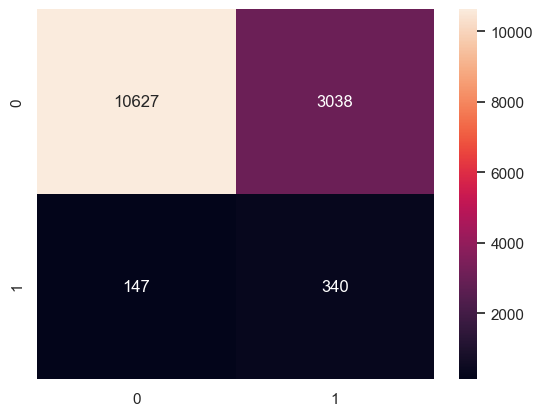

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f')

In [ ]:
df_postulantes["prob_seleccion"] = model.predict_proba(X)[:, 1]


In [ ]:
top_unis = (
    df_postulantes
    .groupby("Universidad")["prob_seleccion"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
print(top_unis)

Universidad
Pontificia U. Católica de Chile                      0.668645
U. Adolfo Ibáñez (Santiago)                          0.626147
Docente de Biología y Ciencias para la Ciudadanía    0.620821
U. Técnica Federico Santa María (Santiago)           0.593457
U. de Los Andes                                      0.582862
Name: prob_seleccion, dtype: float64


In [ ]:
top_carreras = (
    df_postulantes
    .groupby("Carrera")["prob_seleccion"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
print(top_carreras)


Carrera
COLLEGE                                                                                                                                  0.840658
LICENCIATURA EN CIENCIAS SOCIALES CON MAJOR EN FILOSOFIA Y PSICOLOGIA, MINOR EN LITERATURA UNIVERSAL Y MINOR EN CIENCIAS DEL LENGUAJE    0.840658
PEDAGOGIA EN EDUCACION MEDIA EN FISICA                                                                                                   0.832468
PROFESORA DE RELIGION                                                                                                                    0.811546
PLANIFICACION URBANA                                                                                                                     0.810360
Name: prob_seleccion, dtype: float64


In [ ]:
# Mejores universidades + carreras
top_uni_carrera = (
    df_postulantes
    .groupby(["Universidad", "Carrera"])["prob_seleccion"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

print(top_uni_carrera)


Universidad                      Carrera                                                                                                                              
Pontificia U. Católica de Chile  ASTRONOMIA                                                                                                                               0.842517
                                 COLLEGE                                                                                                                                  0.840658
                                 LICENCIATURA EN CIENCIAS SOCIALES CON MAJOR EN FILOSOFIA Y PSICOLOGIA, MINOR EN LITERATURA UNIVERSAL Y MINOR EN CIENCIAS DEL LENGUAJE    0.840658
                                 ESTADISTICA                                                                                                                              0.835164
                                 PEDAGOGIA EN EDUCACION MEDIA EN FISICA                                              

In [ ]:
# Filtramos solo las columnas necesarias: Universidad, Nombre_Carrera, y CORTE_2024
df_2024 = df_final[["Universidad", "NOMBRE_CARRERA", "CORTE_2024"]].copy()

# Convertimos la columna de corte 2024 a numérica por si acaso
df_2024["CORTE_2024"] = pd.to_numeric(df_2024["CORTE_2024"], errors="coerce")

# Filtrar solo las carreras de Ingeniería (que contengan "INGENIERIA" o "INGENIERÍA")
mask_ingenieria = df_2024["NOMBRE_CARRERA"].str.contains("INGENIERIA|INGENIERÍA", case=False, na=False)
df_ingenierias_2024 = df_2024[mask_ingenieria]

# Separar Ingeniería Civil
mask_civil = df_ingenierias_2024["NOMBRE_CARRERA"].str.contains("CIVIL", case=False, na=False)
df_ingenierias_civil_2024 = df_ingenierias_2024[mask_civil]

# Separar Ingeniería Comercial
mask_comercial = df_ingenierias_2024["NOMBRE_CARRERA"].str.contains("COMERCIAL", case=False, na=False)
df_ingenierias_comercial_2024 = df_ingenierias_2024[mask_comercial]

# Ordenar por puntaje de corte 2024 de mayor a menor
df_ingenierias_civil_2024 = df_ingenierias_civil_2024.sort_values(by="CORTE_2024", ascending=False)
df_ingenierias_comercial_2024 = df_ingenierias_comercial_2024.sort_values(by="CORTE_2024", ascending=False)

# Ahora puedes ver los resultados
print("Ingenierías Civiles (2024):")
print(df_ingenierias_civil_2024.head())

print("\nIngenierías Comerciales (2024):")
print(df_ingenierias_comercial_2024.head())


KeyError: "['Universidad'] not in index"

In [274]:
# Filtramos solo las columnas necesarias: Universidad, Nombre_Carrera, y CORTE_2024
df_2024 = df_final[["UNIVERSIDAD", "NOMBRE_CARRERA", "CORTE_2024"]].copy()

# Convertimos la columna de corte 2024 a numérica por si acaso
df_2024["CORTE_2024"] = pd.to_numeric(df_2024["CORTE_2024"], errors="coerce")

# Filtramos todas las ingenierías
mask_ingenieria = df_2024["NOMBRE_CARRERA"].str.contains("INGENIERIA", case=False, na=False)
df_ingenierias = df_2024[mask_ingenieria]

# De estas ingenierías, filtramos las comerciales
mask_comercial = df_ingenierias["NOMBRE_CARRERA"].str.contains("COMERCIAL", case=False, na=False)
df_ingenierias_comercial = df_ingenierias[mask_comercial]

# Y ahora excluimos las comerciales del grupo general para quedarnos con las demás ingenierías
df_ingenierias_no_comercial = df_ingenierias[~mask_comercial]

# Ahora tienes dos DataFrames: uno con ingenierías comerciales y otro con todas las demás ingenierías
print("Ingenierías Comerciales:")
display(df_ingenierias_comercial.head(10))

print("\nOtras Ingenierías:")
display(df_ingenierias_no_comercial.head(10))



Ingenierías Comerciales:


,UNIVERSIDAD,NOMBRE_CARRERA,CORTE_2024
26,UNIVERSIDAD DE CHILE,INGENIERIA COMERCIAL,822.20
69,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,INGENIERIA COMERCIAL,872.90
134,UNIVERSIDAD DE CONCEPCION,INGENIERIA COMERCIAL (CONCEPCION),681.20
144,UNIVERSIDAD DE CONCEPCION,INGENIERIA COMERCIAL (CHILLAN),658.90
185,UNIVERSIDAD DE CONCEPCION,INGENIERIA COMERCIAL (LOS ANGELES),570.70
214,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,INGENIERIA COMERCIAL,694.55
297,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA COMERCIAL,688.50
301,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA EN AVIACION COMERCIAL,671.90
304,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA COMERCIAL,743.70
376,UNIVERSIDAD DE SANTIAGO DE CHILE,INGENIERIA COMERCIAL,712.60



Otras Ingenierías:


,UNIVERSIDAD,NOMBRE_CARRERA,CORTE_2024
7,UNIVERSIDAD DE CHILE,INGENIERIA AGRONOMICA,643.45
8,UNIVERSIDAD DE CHILE,INGENIERIA FORESTAL,501.75
10,UNIVERSIDAD DE CHILE,INGENIERIA EN RECURSOS NATURALES RENOVABLES,621.25
12,UNIVERSIDAD DE CHILE,INGENIERIA EN INFORMACION Y CONTROL DE GESTION,743.75
16,UNIVERSIDAD DE CHILE,INGENIERIA EN ALIMENTOS,529.70
24,UNIVERSIDAD DE CHILE,INGENIERIA EN BIOTECNOLOGIA MOLECULAR,828.10
27,UNIVERSIDAD DE CHILE,INGENIERIA Y CIENCIAS - PLAN COMUN,828.10
55,UNIVERSIDAD DE CHILE,INGENIERIA EN SONIDO,782.80
58,UNIVERSIDAD DE CHILE,INGENIERIA EN RECURSOS HIDRICOS,0.00
68,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,AGRONOMIA E INGENIERIA FORESTAL,713.60


In [278]:
# Ordenamos las ingenierías comerciales de mayor a menor por CORTE_2024
df_ingenierias_comercial_sorted = df_ingenierias_comercial.sort_values(by="CORTE_2024", ascending=False)

# Ordenamos las demás ingenierías de mayor a menor por CORTE_2024
df_ingenierias_no_comercial_sorted = df_ingenierias_no_comercial.sort_values(by="CORTE_2024", ascending=False)

# Mostramos las primeras filas para ver los resultados ordenados
print("Ingenierías Comerciales Ordenadas:")
display(df_ingenierias_comercial_sorted.head(15))

print("\nOtras Ingenierías Ordenadas:")
display(df_ingenierias_no_comercial_sorted.head(15))


Ingenierías Comerciales Ordenadas:


,UNIVERSIDAD,NOMBRE_CARRERA,CORTE_2024
69,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,INGENIERIA COMERCIAL,872.90
1526,UNIVERSIDAD ADOLFO IBANEZ,DOBLE GRADO DERECHO - INGENIERIA COMERCIAL,837.85
26,UNIVERSIDAD DE CHILE,INGENIERIA COMERCIAL,822.20
1537,UNIVERSIDAD DE LOS ANDES,INGENIERIA COMERCIAL,791.05
304,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA COMERCIAL,743.70
1571,UNIVERSIDAD DEL DESARROLLO,INGENIERIA COMERCIAL,741.70
1513,UNIVERSIDAD ADOLFO IBANEZ,"INGENIERIA COMERCIAL, PLAN COMUN",740.45
1518,UNIVERSIDAD ADOLFO IBANEZ,BACHILLERATO DE INGENIERIA COMERCIAL,720.00
1534,UNIVERSIDAD DE LOS ANDES,BACHILLERATO DE INGENIERIA COMERCIAL,716.20
376,UNIVERSIDAD DE SANTIAGO DE CHILE,INGENIERIA COMERCIAL,712.60



Otras Ingenierías Ordenadas:


,UNIVERSIDAD,NOMBRE_CARRERA,CORTE_2024
91,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,INGENIERIA,894.20
173,UNIVERSIDAD DE CONCEPCION,INGENIERIA CIVIL AEROESPACIAL,862.80
27,UNIVERSIDAD DE CHILE,INGENIERIA Y CIENCIAS - PLAN COMUN,828.10
24,UNIVERSIDAD DE CHILE,INGENIERIA EN BIOTECNOLOGIA MOLECULAR,828.10
116,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,LICENCIATURA EN INGENIERIA EN CIENCIA DE LA CO...,818.85
303,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA CIVIL INDUSTRIAL,817.50
283,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA CIVIL MATEMATICA,806.65
296,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA CIVIL INDUSTRIAL,793.60
305,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,INGENIERIA CIVIL PLAN COMUN,788.20
179,UNIVERSIDAD DE CONCEPCION,INGENIERIA CIVIL INDUSTRIAL,787.85


In [281]:
# Tomamos el DataFrame de ingenierías no comerciales
df_no_comercial = df_ingenierias_no_comercial_sorted

# Agrupamos por universidad y calculamos el promedio del corte 2024
promedio_por_universidad = (df_no_comercial.groupby("UNIVERSIDAD")["CORTE_2024"]
                           .mean()
                           .reset_index()
                           .sort_values(by="CORTE_2024", ascending=False))

# Mostramos el resultado
display(promedio_por_universidad.head(20))


,UNIVERSIDAD,CORTE_2024
0,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,777.870000
2,UNIVERSIDAD ADOLFO IBANEZ,697.557143
24,UNIVERSIDAD DE LOS ANDES,682.475000
41,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,664.231429
35,UNIVERSIDAD DIEGO PORTALES,614.030000
19,UNIVERSIDAD DE CHILE,608.766667
1,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,581.360000
29,UNIVERSIDAD DE SANTIAGO DE CHILE,571.109259
30,UNIVERSIDAD DE TALCA,567.577273
26,UNIVERSIDAD DE MAGALLANES,546.683333


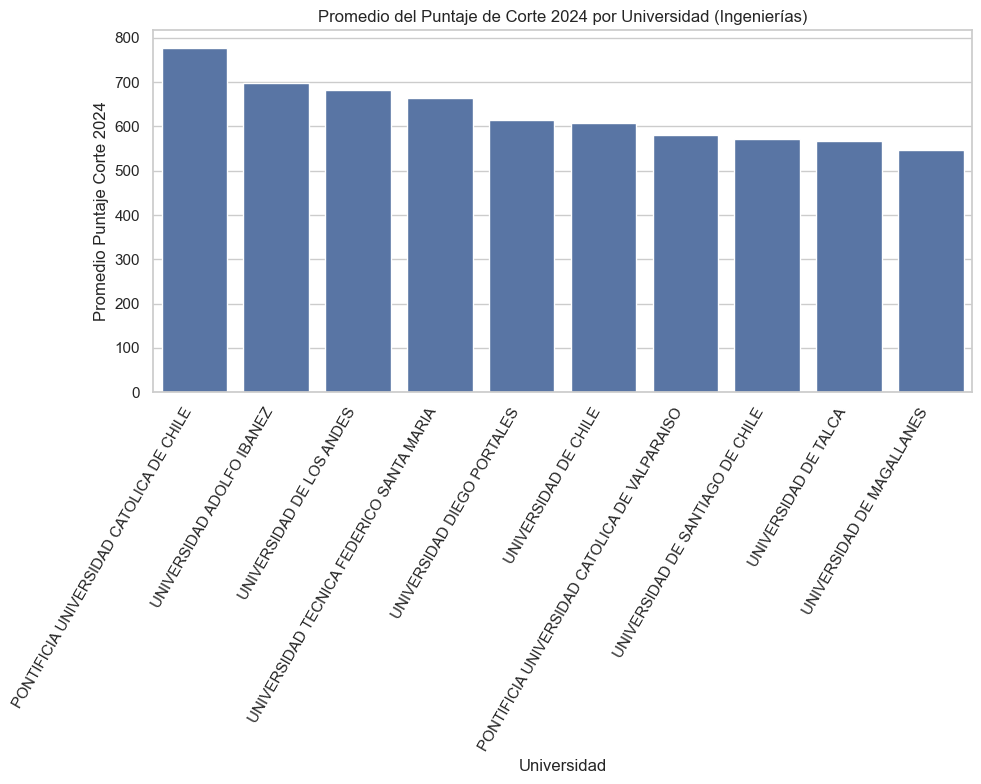

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

top_10_universidades = promedio_por_universidad.head(10)
# Creamos el gráfico de barras
plt.figure(figsize=(10, 8))
sns.barplot(data=top_10_universidades, x="UNIVERSIDAD", y="CORTE_2024")

# Rotamos las etiquetas del eje x para mejor lectura
plt.xticks(rotation=60, ha="right")
plt.title("Promedio del Puntaje de Corte 2024 por Universidad (Ingenierías)")
plt.ylabel("Promedio Puntaje Corte 2024")
plt.xlabel("Universidad")
plt.tight_layout()  # Ajustamos el layout para que no se corten las etiquetas
plt.show()
